## *Import Librairies, Define Variables, Test Connexion*

In [8]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time
from dateutil.relativedelta import relativedelta
import math

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import pmdarima.arima as pm
from scipy.signal import butter,filtfilt

from dateutil.easter import easter

import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [9]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC1_fig'

# @param Connexion à la DB
driver= '{ODBC Driver 17 for SQL Server}'
server = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login = ('DRIVER=' + driver + 
         ';SERVER=' + server + 
         ';Trusted_Connection=yes;')


# @param Definition des TABLE_ENTETE et colonnes --> Dépendent de la DB
DB             = "Delitraiteur_qualif_bacpac.bacpac_20220706"
# TABLE_ENTETE   = "Recette_entete_ticket"
# TEMPS_ENTETE   = TABLE_ENTETE               + ".TEMPS.KEY_Date_reel_de_la_transaction"
# RECETTE_ENTETE = TABLE_ENTETE               + ".Total_net_ticket_ttc"
MAGASIN        = "MAGASIN"


TABLE_DETAIL   = "Recette_detail_ticket_agrege"
TABLE_ARTICLE  = "ARTICLE_METI"
TABLE_HIST     = TABLE_ARTICLE + "_HIST"
RECETTE_DETAIL = TABLE_DETAIL  + ".Total_net_ttc_ligne"
TEMPS_DETAIL   = TABLE_DETAIL  + ".TEMPS.KEY"
# NOM_ARTICLE    = TABLE_ARTICLE + ".Libelle_article_FR"
# name           = "pain"

TABLE_UNIVERS  = "Univers"
univers_key    = 272 


# @param Variable influançant la sélection des données
number_data   = 20263177            # Nombre de données à sélectionner au maximum. MAX = 20263177 avec contraintes
start_date    = date(2018,1,1)      # Date de début des données à sélectionner
end_date      = date(2019,12,1)      # Date de fin des données à sélectionner                                                   
Eat_and_Go_KEYS = [8,18,28,35,36]   # All keys of Eat&Go shops 
take_EG         = False             # Does we take only E&G or does we take only not E&G ? 

do_log  = False
do_shop = False

# @param Input pour la créations du modèles prédictif
alpha = 0.85                  # Proportion de la taille des données de test et de train
season = 7                   # Taille de saisonnalité des données (7 jours pour une saisons par semaines)
METHOD = 'lbfgs'             # Méthode utiliser pour fit le modèle
#          Error Moyenne (%)  TEMPS_ENTETE Process (s)
# newton                 NaN               NaN
# nm               12.929560        108.056167   t=539s bad: 16   moyen: 14   good: 6  ---  E&G t=26s bad: 1   moyen: 0   good: 0
# bfgs             12.620287        556.962607 
# powell           12.670451        379.438504
# lbfgs            12.481309        419.550971   t=770s bad: 9   moyen: 16   good: 10  ---  E&G t=35s bad: 1   moyen: 0   good: 0
# cg               15.907566        217.617969   
# ncg                    NaN               NaN
# basinhopping           NaN               inf


# @param Définition du score d'erreur pour une de bonne/moyenne/mauvaise prédiction
BAD  = .18         # Mauvaise prédiction si score supérieur à BAD
GOOD = .12         # Bonne    prédiction si score inférieur à GOOD


In [10]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+RECETTE_DETAIL+"] FROM ["+DB+"].[DWH].[Fact_"+TABLE_DETAIL+"]", conn)
print(df)

conn.close()

   Recette_detail_ticket_agrege.Total_net_ttc_ligne
0                                           5553.67
1                                           5931.41
2                                          22216.23
3                                          29096.63
4                                          30436.47
5                                          27816.08
6                                          34771.01
7                                          43743.15
8                                          27816.08
9                                          30437.72


## Chargement et Prétraitement des Données 

In [11]:
def date_to_key(d):
    return d.year*10000 + d.month*100 + d.day

def get_timeseries(dataframe, COL_TEMPS, COL_RECETTE, show_plot = False, do_log = False):
    Tot_recette_day = {}

    for i in range(len(dataframe.values)):
        d = int(dataframe[COL_TEMPS][i])
        year  = d//10000
        month = d//100   - year *100
        day   = d        - month*100 - year*10000
        d = date(year,month,day)

        if not d in Tot_recette_day.keys():
            Tot_recette_day[d] = 0
        Tot_recette_day[d] += max(dataframe[COL_RECETTE][i],0)

    if do_log:
        for key in Tot_recette_day.keys():
            Tot_recette_day[key] = math.log(Tot_recette_day[key])/math.log(10)
    
    max_d    = max(Tot_recette_day.keys())
    actual_d = min(Tot_recette_day.keys())
    while actual_d < max_d:
        actual_d += timedelta(days = 1)
        if not actual_d in Tot_recette_day.keys():
            Tot_recette_day[actual_d] = 0
    
    #Sort the items by date is necessary, sometimes it isn't sorted ! ~30 items/month so it's fast
    Tot_recette_day = dict(sorted(Tot_recette_day.items()))

    timeseries = pd.Series(data  = list(Tot_recette_day.values()),
                           index = list(Tot_recette_day.keys()))
    
    if show_plot:
        timeseries.plot(label="Data",legend=True, figsize=(15,7))
        plt.title("Timeserie")
        plt.show()
    
    return timeseries

####  ---------- Décomposition série en moyenne par mois et en différence par rapport à cette moyenne --------- ####
def decompose_series(timeseries, show_plot):
    Mean_recette_month = {}
    number_day_month   = {}
    
    for k in timeseries.index:
        if not date(k.year, k.month, 1) in Mean_recette_month.keys():
            Mean_recette_month[date(k.year, k.month, 1)] = 0
            number_day_month[date(k.year, k.month, 1)]   = 0
        Mean_recette_month[date(k.year, k.month, 1)] += timeseries[k]
        number_day_month[date(k.year, k.month, 1)]   += 1

    for k in Mean_recette_month.keys():
        Mean_recette_month[k] /= number_day_month[k]

    ts_month = pd.Series(data  = Mean_recette_month.values(), 
                         index = Mean_recette_month.keys())
    
    ts_monthless = timeseries.copy()
    for k in ts_monthless.index:
        ts_monthless[k] -= Mean_recette_month[date(k.year, k.month, 1)]
    
    if show_plot:
        ts_month.plot(label="Data",legend=True, figsize=(15,7))
        plt.title("Timeserie month mean")
        plt.show()

        ts_monthless.plot(label="Data",legend=True, figsize=(15,7))
        plt.title("Timeserie monthless")
        plt.show()
    
    
    return ts_month, ts_monthless

#### --------- Application filtre passe-bas ------------ ####
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def get_filtred(timeserie, freq = 365/7, freq_nyq = 365):
    ts_filtred       = pd.Series(data  = butter_lowpass_filter(timeserie.values, int(freq*1.5), freq_nyq, 1), 
                                 index = timeserie.index)
    return ts_filtred

#### ---------- Transformation en fenêtre pour le réseaux de neuronnes -------- ####
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

In [ ]:
sql_command = '''SELECT TOP (''' + str(number_data) + ''') 
 ['''      + TEMPS_ENTETE   + ''']
,['''      + RECETTE_ENTETE + ''']
,['''      + TABLE_ENTETE   + '''.'''        + MAGASIN      + '''.KEY]
FROM  [''' + DB      + '''].[DWH].[Fact_''' + TABLE_ENTETE + ''']
WHERE [''' + RECETTE_ENTETE + '''] != 0  
AND ['''   + TEMPS_ENTETE   + '''] > ''' + str(date_to_key(start_date)) + '''
AND ['''   + TEMPS_ENTETE   + '''] < ''' + str(date_to_key(end_date))   + '''
AND ['''   + TABLE_ENTETE   + '''.Nombre_articles] > 0 '''

if not take_EG:
    for key in Eat_and_Go_KEYS:
        sql_command += "\nAND NOT " +  "["+TABLE_ENTETE+"."+MAGASIN+".KEY] = " + str(key)
else: 
    sql_command += "\nAND ("
    for key in Eat_and_Go_KEYS:
        sql_command += "["+TABLE_ENTETE+"."+MAGASIN+".KEY] = " + str(key) + " \nOR "
    sql_command = sql_command[:-3]+")"

print(sql_command)

start = time()

conn = engine.connect()
df = pd.read_sql(sql_command, conn)
conn.close()

# environ 2 min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 

number_data = len(df.values)
print(number_data)

SELECT TOP (11901940) 
 [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction]
,[Recette_entete_ticket.Total_net_ticket_ttc]
,[Recette_entete_ticket.MAGASIN.KEY]
FROM  [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket]
WHERE [Recette_entete_ticket.Total_net_ticket_ttc] != 0  
AND [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] > 20180101
AND [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] < 20191201
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 8
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 18
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 28
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 35
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 36


In [ ]:
sql_command = '''  
SELECT [''' + MAGASIN + '''.KEY]
      ,[''' + MAGASIN + '''.Libelle_magasin]
FROM ['''   + DB      + '''].[DWH].[Dim_'''+MAGASIN+''']
'''
print(sql_command)


conn = engine.connect()
df_magasin = pd.read_sql(sql_command, conn)
conn.close()


print(df_magasin)

## Analyse des données

In [12]:
def stationarity_test(ts):
    df_test = adfuller(ts, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of observations used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    return df_output

In [13]:
def Analysis(ts_main, COL_TEMPS, COL_RECETTE, season):
    print(ts_main)

    decomp = sm.tsa.seasonal_decompose(ts_main, period = season, model='additive')
    decomp.plot()
    plt.show()

    plot_acf(ts_main,lags = 30, title = "Auto-corrélation sur la série")
    plt.show()
    plot_pacf(ts_main, lags = 30, title = "Auto-corrélation  partielle sur la série")
    plt.show()

    print(stationarity_test(ts_main))

    ts_d1 = pd.Series(data=ts_main - ts_main.shift(1), index=ts_main.index).dropna()       

    plt.figure(figsize=(15,7))
    plt.plot(ts_d1.index, ts_d1.values)
    plt.title("Différence of CA")
    plt.show()

    print(stationarity_test(ts_d1))

    decomp_d1 = sm.tsa.seasonal_decompose(ts_d1,period = season, model='additive')
    decomp_d1.plot()
    plt.show()

    plot_acf(ts_d1,lags = 30, title = "Auto-corrélation sur la différenciation première")
    plt.show()
    plot_pacf(ts_d1, lags = 30, title = "Auto-corrélation partielle sur la différenciation première")
    plt.show()

    ts_d1ds = pd.Series(data=ts_d1 - ts_d1.shift(season), index=ts_d1.index).dropna()  

    plot_acf(ts_d1ds,lags = 30, title = "Auto-corrélation sur la différenciation saisonière")
    plt.show()
    plot_pacf(ts_d1ds, lags = 30, title = "Auto-corrélation partielle sur la différenciation saisonière")
    plt.show()

## Modèle SARIMA sur la série principale

In [14]:
def cal_error(prediction, validation):
    # ERREURS QUADRATIQUES --- Metrics pour comparer les modèles 
    prediction = list(prediction.values)
    validation = list(validation.values)
    
    N = len(validation)
    
    erreurs_quad = [(prediction[i] - validation[i])**2 for i in range(N)]
    
    MSE = (sum(erreurs_quad)/N)
    RMSE = MSE**0.5
    NRMSD = RMSE/(max(validation)-min(validation))
    
    return NRMSD

In [15]:
def Recalc_with_feries(prediction):
    jours_feries = []

    d = min(prediction.index)
    while d <= max(prediction.index):
        if d.day == 1 and d.month == 1:
            jours_feries.append(d)
        elif d.day == 1 and d.month == 5:
            jours_feries.append(d)
        elif d.day == 21 and d.month == 7:
            jours_feries.append(d)
        elif d.day == 15 and d.month == 8:
            jours_feries.append(d)
        elif d.day == 1 and d.month == 11:
            jours_feries.append(d)
        elif d.day == 11 and d.month == 11:
            jours_feries.append(d)
        elif d.day == 25 and d.month == 12:
            jours_feries.append(d)
            
        paques = easter(d.year)
        lundi_paques = paques + timedelta(days=1)
        ascension    = paques + timedelta(days=40)
        pentecote    = paques + timedelta(days=50)
        
        if d==lundi_paques or d==ascension or d==pentecote:
            jours_feries.append(d)
        d+=timedelta(days=1)

    for jf in jours_feries:
        maximum = 0
        for i in range(-season,season):
            if jf + timedelta(days=i) in prediction.index:
                maximum = max(prediction[jf + timedelta(days=i)], maximum)
        prediction[jf] = maximum
    return prediction

In [16]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~0secondes


## *Prediction du CA en fonction du TEMPS_ENTETE par Magasin*

In [17]:
if do_shop:
    all_mag_key = set(df[TABLE_ENTETE+"."+MAGASIN+".KEY"])

    all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
    all_mag_rec = {mag_key:{} for mag_key in all_mag_key}

    ind_TEMPS_ENTETE = len(df.columns)-1
    ind_recette = list(df.columns).index(RECETTE_ENTETE)
    ind_mag = list(df.columns).index(TABLE_ENTETE+"."+MAGASIN+".KEY")

    for val in df.values:
        if not val[ind_TEMPS_ENTETE] in all_mag_rec[val[ind_mag]].keys():
            all_mag_rec[val[ind_mag]][val[ind_TEMPS_ENTETE]] = 0
        all_mag_rec[val[ind_mag]][val[ind_TEMPS_ENTETE]] += val[ind_recette]


    bad, moyen, good = 0,0,0    

    for mag_key in all_mag_key:
        start = time()

        Tot_recette_day = all_mag_rec[mag_key]
        mag_lib = all_mag_lib[mag_key]

        Tot_recette_day = dict(sorted(Tot_recette_day.items()))

        df_recette_day_mag = pd.DataFrame(data  = Tot_recette_day.values(), 
                                          index = Tot_recette_day.keys(), 
                                          columns = ["Total Recette"])

        if not df_recette_day_mag.empty:
            if len(df_recette_day_mag.values) > season * 10:
                ts_main_mag     = pd.Series(data = df_recette_day_mag[df_recette_day_mag.columns[0]], 
                                                                        index=df_recette_day_mag.index)


                train_main_mag, val_main_mag = train_test_split(ts_main_mag,test_size = 1-alpha, shuffle = False)


                pred_mag        = pm.auto_arima(train_main_mag,d=0,D=1,seasonal=True, m=season, 
                                            method = METHOD).fit_predict(train_main_mag, n_periods = len(val_main_mag))
                pred_mag        = pd.Series(data=pred_mag,
                                            index=[train_main_mag.index[-1] +timedelta(days=i+1) for i in range(len(pred_mag))])

                if not take_EG:
                    pred_mag        = Recalc_with_feries(pred_mag)

                err = cal_error(pred_mag, val_main_mag)

                train_main_mag[-season*8:].plot(label="Data",legend=True, figsize=(15,7))
                val_main_mag.plot(label="Data_VAL",legend=True, figsize=(15,7))
                pred_mag.plot(label = "Prédiction" ,legend=True)
                plt.title(mag_lib + " - Données & prédictions.  Error Score = " + str(int(err*100)) + " %")
                if save_fig:
                    plt.savefig(save_folder+ "/MAG-" +mag_lib + "-prediction.jpg")
                plt.show()

                bad   += int(bool(err>BAD))
                moyen += int(bool(err<BAD and err >GOOD))
                good  += int(bool(err<GOOD))

            else:  
                df_recette_day_mag.plot(figsize=(15,7), title = mag_lib)
                plt.show()

        print("Time taken for magasin " + str(mag_key) +"/"+str(max(all_mag_key))+ " " + (mag_lib if mag_lib != None else "?")
              + ": ~" + str(int(time() - start)) + " secondes") 

    print("bad:",bad,"  moyen:", moyen,"  good:", good)

In [18]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~0secondes


## Analyse des différentes méthode de SARIMA en auto-arima

In [19]:
if do_shop:
    results = {'nm'    :[12.929560,108.056167],
               'bfgs'  :[12.620287,556.962607],
               'powell':[12.670451,379.438504],
               'lbfgs' :[12.481309,419.550971],
               'cg'    :[15.907566,217.617969]}

    all_mag_key = set(df[TABLE_ENTETE+"."+MAGASIN+".KEY"])

    all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
    all_mag_rec = {mag_key:{} for mag_key in all_mag_key}

    ind_TEMPS_ENTETE = len(df.columns)-1
    ind_recette = list(df.columns).index(RECETTE_ENTETE)
    ind_mag = list(df.columns).index(TABLE_ENTETE+"."+MAGASIN+".KEY")

    for val in df.values:
        if not val[ind_TEMPS_ENTETE] in all_mag_rec[val[ind_mag]].keys():
            all_mag_rec[val[ind_mag]][val[ind_TEMPS_ENTETE]] = 0
        all_mag_rec[val[ind_mag]][val[ind_TEMPS_ENTETE]] += val[ind_recette]


    all_df = {}    
    for mag_key in all_mag_key:
        Tot_recette_day = all_mag_rec[mag_key]
        mag_lib = all_mag_lib[mag_key]

        Tot_recette_day = dict(sorted(Tot_recette_day.items()))

        if len(Tot_recette_day.values()) > season * 8:
            all_df[mag_key] =  (mag_lib, pd.DataFrame(data = Tot_recette_day.values(), 
                                              index=Tot_recette_day.keys(), 
                                              columns = ["Total Recette"]))

    for m in results.keys():
        if len(results[m]) > 1:
            continue

        precision = 0
        TEMPS_ENTETE = time()
        n = 20  #Max n ~= 36

        for (mag_key, (mag_lib, df_recette_day_mag)) in list(all_df.items())[:n]:
            start = time()

            ts_main_mag     = pd.Series(data = df_recette_day_mag[df_recette_day_mag.columns[0]], 
                                                                    index=df_recette_day_mag.index)

            train_main_mag, val_main_mag = train_test_split(ts_main_mag,test_size = 1-alpha, shuffle = False)

            pred_mag        = pm.auto_arima(train_main_mag,d=0,D=1,seasonal=True, m=season, 
                                            method = m).fit_predict(train_main_mag, n_periods = len(val_main_mag))
            pred_mag        = pd.Series(data=pred_mag,
                                        index=[train_main_mag.index[-1] +timedelta(days=i+1) for i in range(len(pred_mag))])
            pred_mag        = Recalc_with_feries(pred_mag)

            err             = cal_error(pred_mag, val_main_mag)
            precision      += err

            print("Time taken for magasin " + str(mag_key) + " " + (mag_lib if mag_lib != None else "?")
                  + ": ~" + str(int(time() - start)) + " secondes. " + 
                  "\nMethod = " + m + " Error = " + str(err)) 


        results[m] = [precision*100/n, time()-TEMPS_ENTETE]

    print('-----------------------------------------------------------------')
    print(pd.DataFrame(data = results.values(), 
                    index=results.keys(), 
                    columns = ["Erreur Moyenne (%)", "TEMPS_ENTETE Process"]))
    print("Newton-Raphson & Newton Conjugate Gradient methods don't work for non-convex fonction.")
    print("Powell doesn't seem to work for all dataset ?")
    print("Basinhopping really takes a lot of time to run.")
    print('-----------------------------------------------------------------')

## Chargement des données sur les articles

In [31]:
def base_SARIMA(timeseries, alpha, season, method, show_plot = False, val = []):
    train_main, val_main = train_test_split(timeseries,test_size = 1-alpha, shuffle = False)
    auto_model = pm.auto_arima(train_main,seasonal=True, D=1, m=season, method = method).fit(train_main)
    
    val_main = val if len(val) else val_main
    
    pred = auto_model.predict(n_periods = len(val_main))
    pred = pd.Series(data  = pred, 
                     index = val_main.index)
    
    if season == 7:
        pred = Recalc_with_feries(pred)
    
    err = cal_error(pred, val_main)
    
    if show_plot:
        val_main.plot(label="Data",legend=True, figsize=(15,7))
        pred.plot(label="Prédiction" ,legend=True)
        plt.title("Prédiction with SARIMA")
        plt.show()
    
    return auto_model, pred, err


In [32]:
def decomp_SARIMA(val_main, ts_month, ts_monthless, alpha, season, method, show_plot):
    model_monthless, pred_monthless, _ = base_SARIMA(ts_monthless,      alpha, season, method, False)
    model_month,     pred_month    , _ = base_SARIMA(ts_month    , alpha-0.05,     12, method, False)
    
    new_pred  = pred_monthless.copy()
    mean_pred = sum(pred_monthless.values)/len(pred_monthless)
    for k in new_pred.index:
        if not date(k.year, k.month, 1) in pred_month.index:
            return None, None, [], 0
        new_pred[k] += pred_month[date(k.year, k.month, 1)] - mean_pred
    
    err = cal_error(new_pred, val_main)
    
    if show_plot:
        val_main.plot(label="Data",legend=True, figsize=(15,7))
        new_pred.plot(label="Prédiction" ,legend=True)
        plt.title("Prédiction with Decomposed SARIMA")
        plt.show()
    
    return model_monthless, model_month, new_pred, err

In [22]:

######################################################
# Reshape input to be [samples, time steps, features]
def LSTMmodel(trainX, trainY, seq_size):
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

    print('Single LSTM with hidden Dense...')
    model = Sequential()
    model.add(LSTM(64, input_shape=(None, seq_size)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
    #                        verbose=1, mode='auto', restore_best_weights=True)

    
    model.fit(trainX, trainY,
          verbose=0, epochs=100)
    
    return model
#########################################

#Stacked LSTM with 1 hidden dense layer
# reshape input to be [samples, time steps, features]
def stackedLSTM(trainX, trainY, seq_size):
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    
    model.fit(trainX, trainY,
          verbose=0, epochs=100)
    
    return model
###############################################

#Bidirectional LSTM
# reshape input to be [samples, time steps, features]
def bidirectionalLSTM(trainX, trainY, seq_size):
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

    #For some sequence forecasting problems we may need LSTM to learn
    # sequence in both forward and backward directions
    from keras.layers import Bidirectional
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(trainX, trainY,
          verbose=0, epochs=100)
    
    print(trainX.shape)
    return model

#########################################################
#ConvLSTM
#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

def ConvLSTM(trainX, trainY, seq_size):
    trainX = train.reshape((trainX.shape[0], 1, 1, 1, seq_size))
#     testX = val.reshape((val.shape[0], 1, 1, 1, seq_size))

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(trainX, trainY,
          verbose=0, epochs=100)
    
    return model

In [23]:
def neural(ts_main, window, alpha, show_plot):
    scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
    dataset = scaler.fit_transform([[v] for v in ts_main.values])

    train, test = train_test_split(dataset,test_size = 1-alpha, shuffle = False)
    
    trainX, trainY = to_sequences(train, window)

    model = stackedLSTM(trainX, trainY, window)
    
    pred = []
    start = trainX[-1]

    N_val = len(ts_main)-len(trainX)
    for i in range(N_val):
        p = model.predict(np.array([[start]]), verbose = 0)[0]

        start = np.append(start[1:],p)
        pred  = np.append(pred, [p])

        
    pred = scaler.inverse_transform([[v] for v in pred])
    val_ts_predict = pd.Series(data = pred[:,0], index = ts_main.index[-N_val:])

    err = cal_error(val_ts_predict,  ts_main[-N_val:])
    
    if show_plot:
        plt.figure(figsize=(15,7))
        val_ts_predict.plot()
        ts_main.plot()
        plt.show()
    
    return model, val_ts_predict,err

In [24]:
def neural_decomp(val_main, ts_month, ts_monthless, alpha, season, method, show_plot):
    model_monthless, pred_monthless, _ = base_SARIMA(ts_monthless,      alpha, season, method, False)
    model_month,     pred_month    , _ = neural(ts_month         , 3  , alpha, False)
    
    new_pred  = pred_monthless.copy()
    mean_pred = sum(pred_monthless.values)/len(pred_monthless)
    for k in new_pred.index:
        new_pred[k] += pred_month[date(k.year, k.month, 1)] - mean_pred
    
    err = cal_error(new_pred, val_main)
    
    if show_plot:
        val_main.plot(label="Data",legend=True, figsize=(15,7))
        new_pred.plot(label="Prédiction" ,legend=True)
        plt.title("Prédiction with Decomposed SARIMA")
        plt.show()
    
    return model_monthless, model_month, new_pred, err

In [25]:
def get_forecast(ts_main, COL_TEMPS, COL_RECETTE, alpha = 0, season = 7, method = 'lbfgs', model = None, show_plot = False):
    start = time()

    if alpha == 0:
        alpha = max(1-100/len(ts_main), 0.8)
    
    ts_month, ts_monthless = decompose_series(ts_main, False)
    time_decomp = time()-start
    
    _, val_main = train_test_split(ts_main,test_size = 1-alpha, shuffle = False)
    print("Decomposition loaded ...", int(time_decomp), "s")
    
    err_base           = None
    err_base_decomp    = None
    err_filtred        = None
    err_filtred_decomp = None
    err_neural_decomp  = None
    
    
    (model_base, 
     pred_base, 
     err_base) = base_SARIMA(ts_main, alpha, season, method, show_plot)
    print(err_base)
    time_base = time()-start
    print("Base Model loaded ...", int(time_base-time_decomp), "s")
    
    if len(ts_month) > 24:
        (model_base_monthless, 
         model_base_month, 
         pred_base_decomp, 
         err_base_decomp) = decomp_SARIMA(val_main, ts_month, ts_monthless, alpha, season, method, show_plot)
        print(err_base_decomp)
    time_base_decomp = time()-start
    print("Base Decomp Model loaded ...", int(time_base_decomp-time_base), "s")

    ts_filtred       = get_filtred(ts_main)
    ts_day_filtred   = get_filtred(ts_monthless)
    time_filtring = time()-start
    print("Filtring time ...", int(time_filtring-time_base_decomp), "s")
        
    (model_filtred, 
     pred_filtred, 
     err_filtred) = base_SARIMA(ts_filtred, alpha, season, method, show_plot, val_main)
    print(err_filtred)
    time_filtred = time()-start
    print("Filtred Model loaded ...", int(time_filtred-time_filtring), "s")
        
    if len(ts_month) > 24:
        (model_filtred_monthless, 
         model_filtred_month, 
         pred_filtred_decomp, 
         err_filtred_decomp) = decomp_SARIMA(val_main, ts_month, ts_day_filtred, alpha, season, method, show_plot)
        print(err_filtred_decomp)
    time_filtred_decomp = time()-start
    print("Filtred Decomp Model loaded ...", int(time_filtred_decomp-time_filtred), "s")
        
    if len(ts_month) > 24:
        (model_neural_monthless, 
         model_neural_month, 
         pred_neural_decomp, 
         err_neural_decomp) = neural_decomp(val_main, ts_month, ts_monthless, alpha, season, method, show_plot)
        print(err_neural_decomp)
    time_neural = time()-start
    print("Neural Decomp Model loaded ...", int(time_neural-time_filtred_decomp), "s")
    
    return pd.DataFrame(data = [[time_base-time_decomp           , err_base], 
                                [time_base_decomp-time_base      , err_base_decomp],
                                [time_filtred-time_base_decomp   , err_filtred],
                                [time_filtred_decomp-time_filtred, err_filtred_decomp],
                                [time_neural-time_filtred_decomp , err_neural_decomp]],
                        index = ["Base", "Base Decomp", "Filtred", "Filtred Decomp", "Neural Decomp"],
                        columns = ["Time", "Error"]
                       )

In [21]:
sql_command = '''SELECT ['''+RECETTE_DETAIL+''']
,['''+TEMPS_DETAIL+''']
FROM ['''+DB+'''].[DWH].[Fact_'''+TABLE_DETAIL+''']
INNER JOIN ['''+DB+'''].[DWH].[Dim_'''+TABLE_HIST+''']
ON ['''+TABLE_HIST+'''.KEY] = ['''+TABLE_DETAIL+'''.'''+TABLE_HIST+'''.KEY]
INNER JOIN ['''+DB+'''].[DWH].[Dim_'''+TABLE_ARTICLE+''']
ON ['''+TABLE_ARTICLE+'''.KEY] = ['''+TABLE_HIST+'''.'''+TABLE_ARTICLE+'''.KEY]
WHERE ['''+NOM_ARTICLE+'''] like '%'''+name+'''%' ''' # + ''' AND ['''+TEMPS_DETAIL+'''] > 20191000'''

# sql_command = '''SELECT ['''+RECETTE_DETAIL+''']
# ,['''+TEMPS_DETAIL+''']
# FROM ['''+DB+'''].[DWH].[Fact_'''+TABLE_DETAIL+''']
# INNER JOIN ['''+DB+'''].[DWH].[Dim_'''+TABLE_HIST+''']
# ON ['''+TABLE_HIST+'''.KEY] = ['''+TABLE_DETAIL+'''.'''+TABLE_HIST+'''.KEY]
# WHERE ['''+TABLE_HIST+'''.'''+TABLE_UNIVERS+'''.KEY] = '''+str(univers_key) # + ''' AND ['''+TEMPS_DETAIL+'''] > 20191000'''


print(sql_command)

start = time()

conn = engine.connect()
df_article = pd.read_sql(sql_command, conn)
conn.close()

# environ 3 min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 

nbr_data = len(df_article.values)
print(nbr_data)

SELECT [Recette_detail_ticket.Total_net_ttc_ligne]
,[Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction]
FROM [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Dim_ARTICLE_METI_HIST]
ON [ARTICLE_METI_HIST.KEY] = [Recette_detail_ticket.ARTICLE_METI_HIST.KEY]
INNER JOIN [Archive2018_2019_prod].[DWH].[Dim_ARTICLE_METI]
ON [ARTICLE_METI.KEY] = [ARTICLE_METI_HIST.ARTICLE_METI.KEY]
WHERE [ARTICLE_METI.Libelle_article_FR] like '%pain%' 
Time Taken to load DB: ~149secondes
3500137


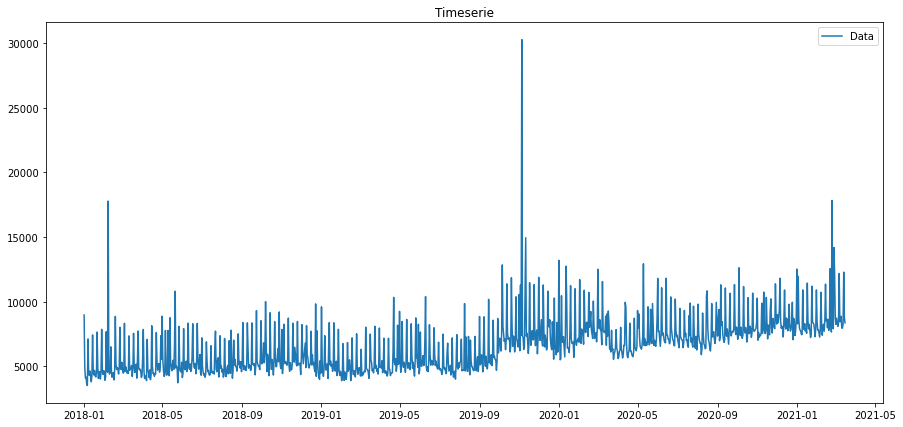

Timeseries loaded ... 41 s


In [22]:
start = time()
ts_article = get_timeseries(df_article, TEMPS_DETAIL, RECETTE_DETAIL, show_plot=True)
print("Timeseries loaded ...", int(time()-start), "s")

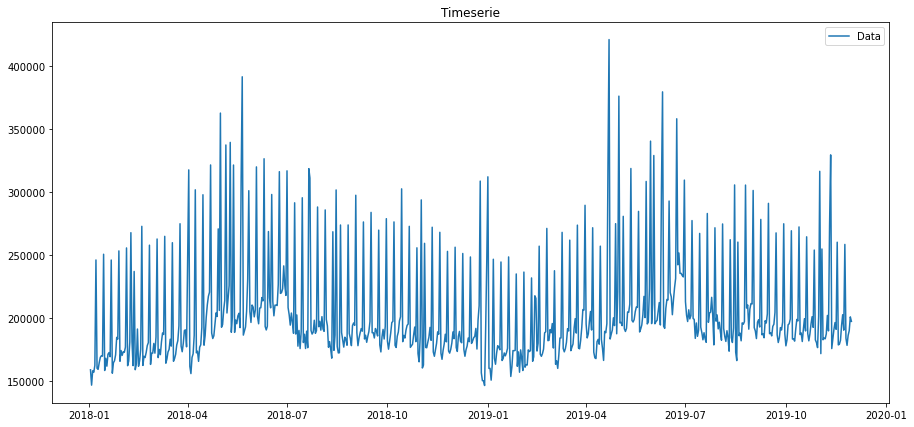

Timeseries loaded ... 145 s


In [23]:
start = time()
ts_all = get_timeseries(df, TEMPS_ENTETE, RECETTE_ENTETE, show_plot=True)
print("Timeseries loaded ...", int(time()-start), "s")

Decomposition loaded ... 0 s


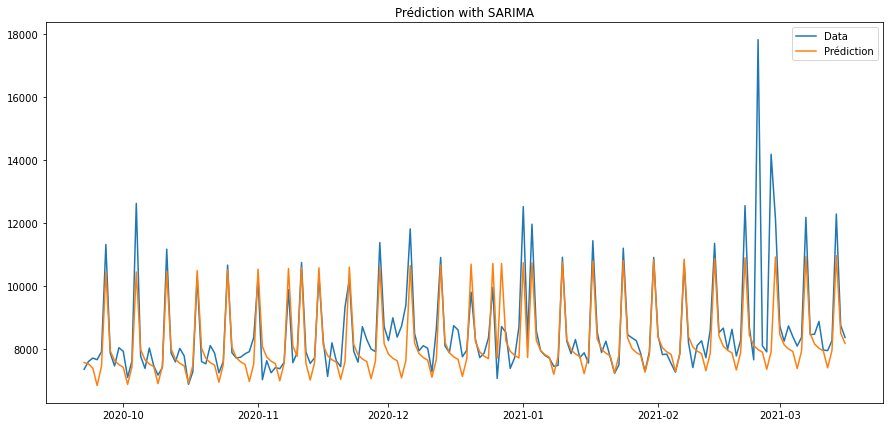

1066.4653124057188
Base Model loaded ... 47 s
Base Decomp Model loaded ... 0 s
Filtring time ... 0 s


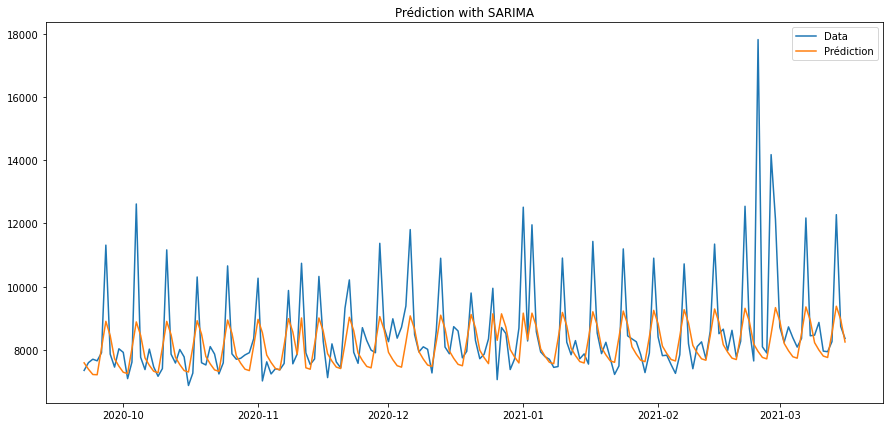

1306.7798317755821
Filtred Model loaded ... 42 s
Filtred Decomp Model loaded ... 0 s


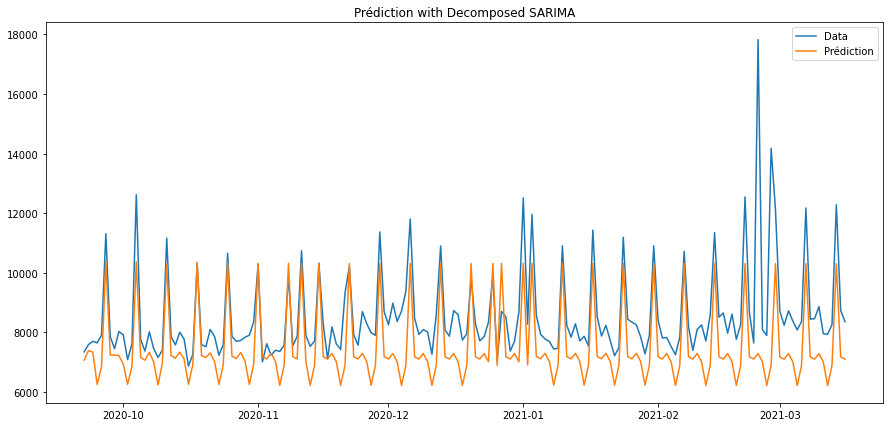

1471.043458260251
Neural Decomp Model loaded ... 31 s


Time        Error
Base            47.146519  1066.465312
Base Decomp      0.000000          NaN
Filtred         42.465326  1306.779832
Filtred Decomp   0.000000          NaN
Neural Decomp   31.663569  1471.043458

In [24]:
get_forecast(ts_article, TEMPS_DETAIL, RECETTE_DETAIL, alpha, season, method = METHOD, show_plot=True)

Decomposition loaded ... 0 s


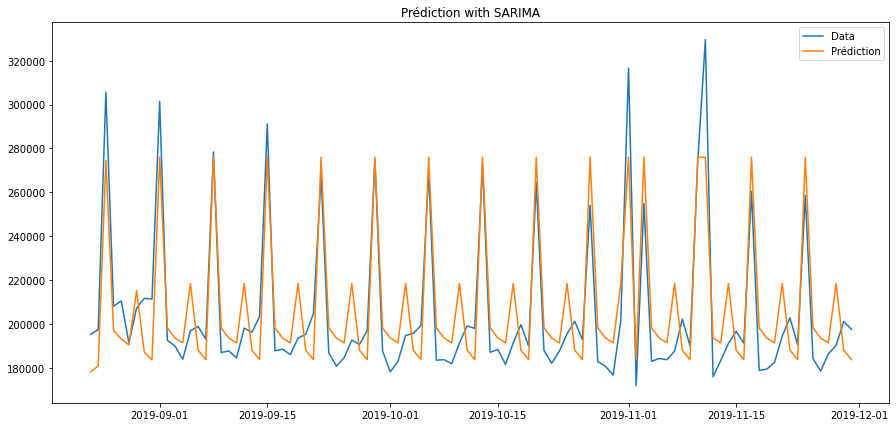

16344.337490382431
Base Model loaded ... 27 s
Base Decomp Model loaded ... 0 s
Filtring time ... 0 s


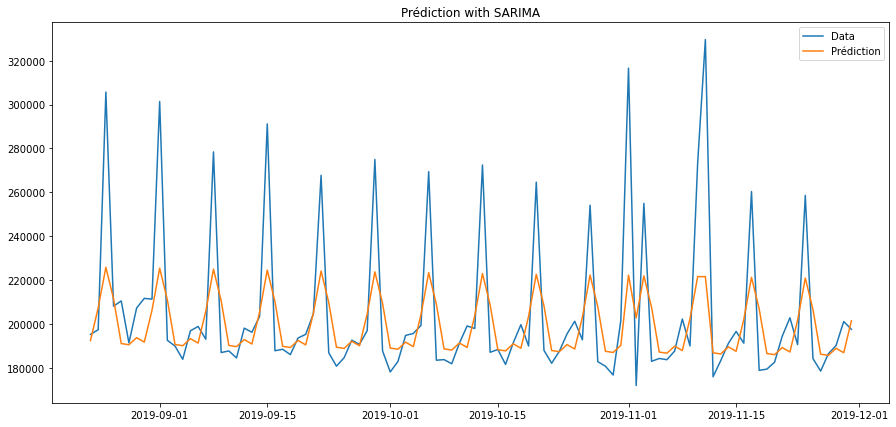

26550.990775068305
Filtred Model loaded ... 29 s
Filtred Decomp Model loaded ... 0 s
Neural Decomp Model loaded ... 0 s


Time         Error
Base            27.280949  16344.337490
Base Decomp      0.000000           NaN
Filtred         29.773326  26550.990775
Filtred Decomp   0.000000           NaN
Neural Decomp    0.000000           NaN

In [25]:
get_forecast(ts_all, TEMPS_ENTETE, RECETTE_ENTETE, 0, season, method = METHOD, show_plot=True)

In [26]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~648secondes


## Analyse de la série temporelle des articles

2018-01-01     8962.92
2018-01-02     4884.69
2018-01-03     4099.85
2018-01-04     4159.08
2018-01-05     3570.74
                ...   
2021-03-12     7937.85
2021-03-13     8257.89
2021-03-14    12279.91
2021-03-15     8740.47
2021-03-16     8357.72
Length: 1171, dtype: float64


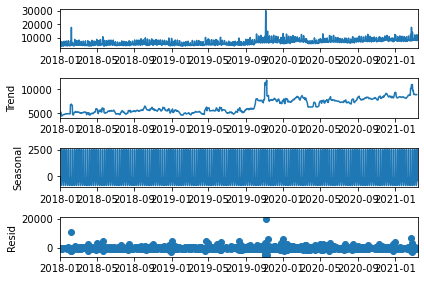

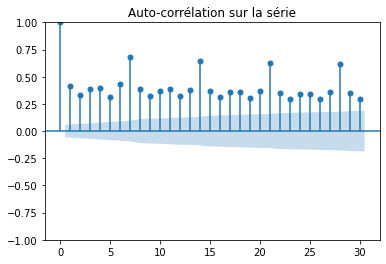

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


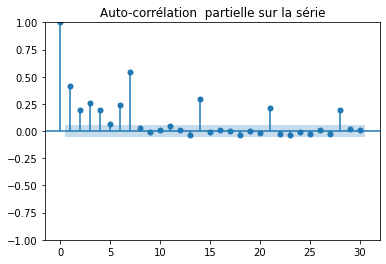

Test Statistic                   -1.188043
p-value                           0.678718
#Lags Used                       20.000000
Number of observations used    1150.000000
Critical Value (1%)              -3.436049
Critical Value (5%)              -2.864057
Critical Value (10%)             -2.568110
dtype: float64


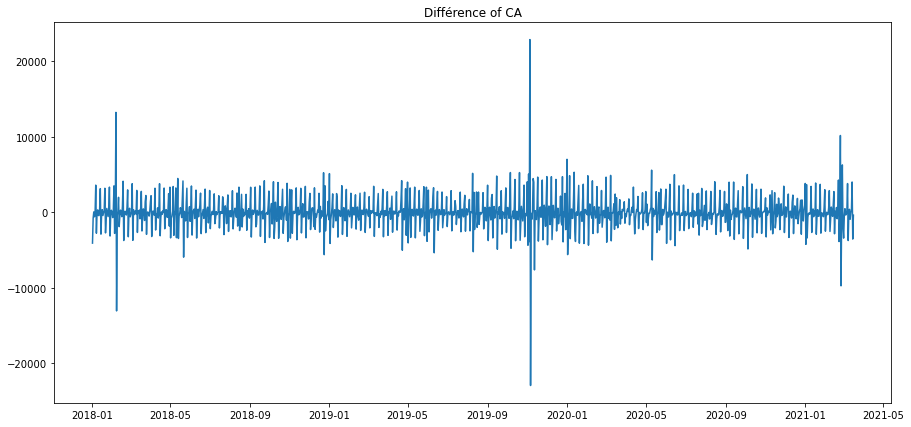

Test Statistic                -1.329103e+01
p-value                        7.362399e-25
#Lags Used                     1.900000e+01
Number of observations used    1.150000e+03
Critical Value (1%)           -3.436049e+00
Critical Value (5%)           -2.864057e+00
Critical Value (10%)          -2.568110e+00
dtype: float64


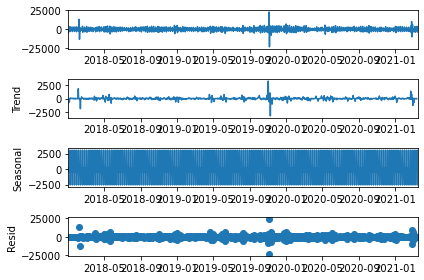

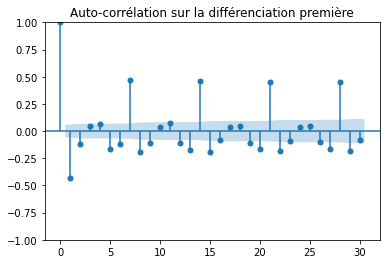

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


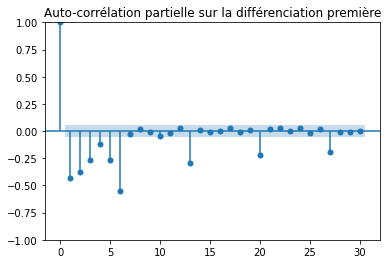

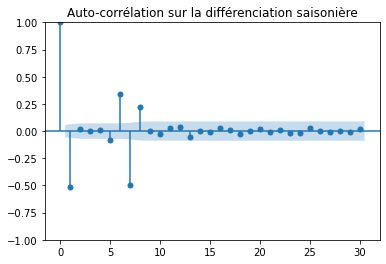

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


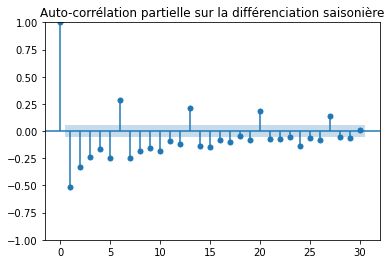

In [27]:
Analysis(ts_article, TEMPS_DETAIL, RECETTE_DETAIL, season)

2018-01-02    159104.90
2018-01-03    146946.93
2018-01-04    158324.82
2018-01-05    157186.65
2018-01-06    162579.42
                ...    
2019-11-26    178521.36
2019-11-27    186388.53
2019-11-28    190136.14
2019-11-29    201107.66
2019-11-30    197543.81
Length: 698, dtype: float64


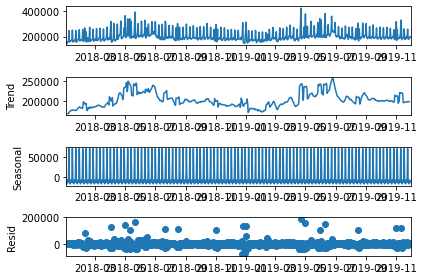

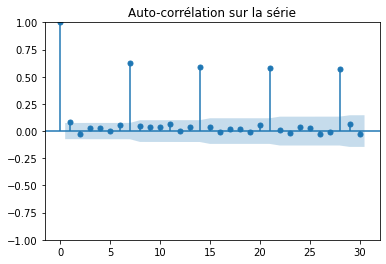

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


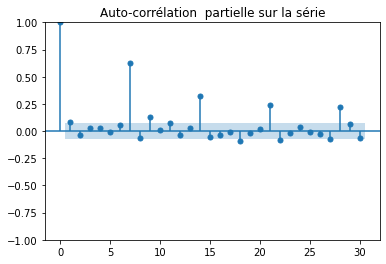

Test Statistic                  -2.531807
p-value                          0.107926
#Lags Used                      20.000000
Number of observations used    677.000000
Critical Value (1%)             -3.440046
Critical Value (5%)             -2.865819
Critical Value (10%)            -2.569049
dtype: float64


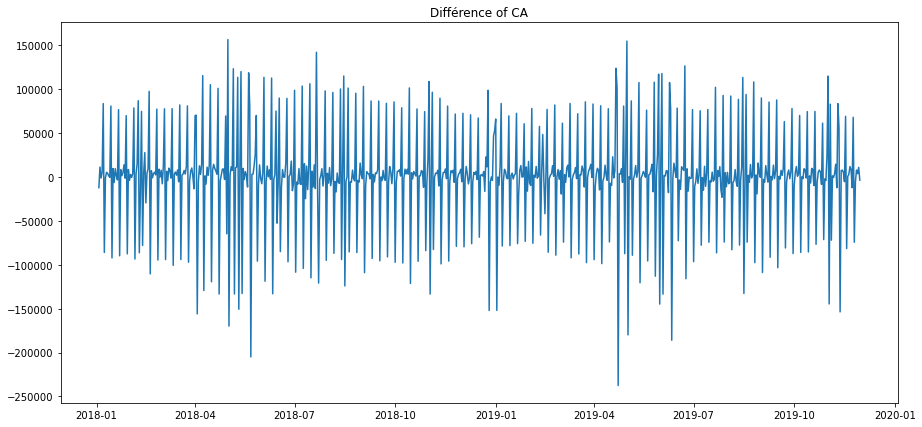

Test Statistic                -8.639284e+00
p-value                        5.481699e-14
#Lags Used                     2.000000e+01
Number of observations used    6.760000e+02
Critical Value (1%)           -3.440061e+00
Critical Value (5%)           -2.865825e+00
Critical Value (10%)          -2.569052e+00
dtype: float64


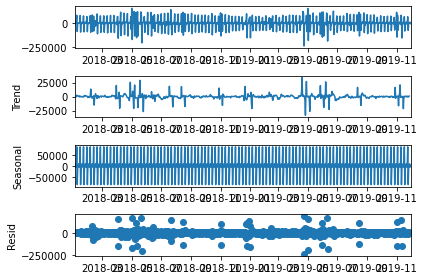

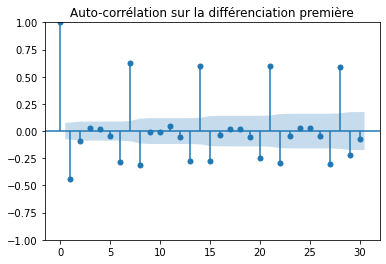

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


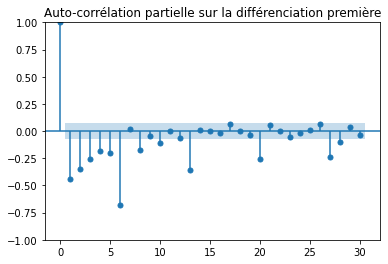

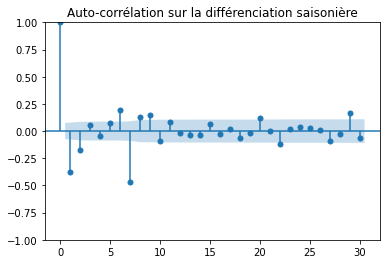

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


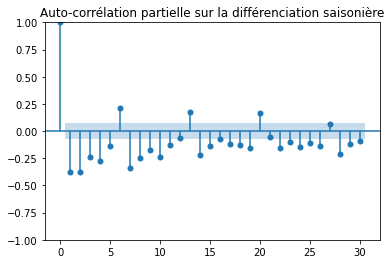

In [28]:
Analysis(ts_all, TEMPS_ENTETE, RECETTE_ENTETE, season)

In [29]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~655secondes


## Run des algos sur un ensemble d'univers

In [57]:
R = range(200,250)

sql_command = '''SELECT ['''+RECETTE_DETAIL+''']
    ,['''+TEMPS_DETAIL+'''],
    ['''+TABLE_HIST+'''.'''+TABLE_UNIVERS+'''.KEY]
    FROM ['''+DB+'''].[DWH].[Fact_'''+TABLE_DETAIL+''']
    INNER JOIN ['''+DB+'''].[DWH].[Dim_'''+TABLE_HIST+''']
    ON ['''+TABLE_HIST+'''.KEY] = ['''+TABLE_DETAIL+'''.'''+TABLE_HIST+'''.KEY]
    WHERE ['''+TABLE_HIST+'''.'''+TABLE_UNIVERS+'''.KEY] >= '''+str(min(R)) +'''
    AND  ['''+TABLE_HIST+'''.'''+TABLE_UNIVERS+'''.KEY] <= '''+str(max(R))

print(sql_command)

start = time()

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 4 min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 

SELECT [Recette_detail_ticket_agrege.Total_net_ttc_ligne]
    ,[Recette_detail_ticket_agrege.TEMPS.KEY],
    [ARTICLE_METI_HIST.Univers.KEY]
    FROM [Delitraiteur_qualif_bacpac.bacpac_20220706].[DWH].[Fact_Recette_detail_ticket_agrege]
    INNER JOIN [Delitraiteur_qualif_bacpac.bacpac_20220706].[DWH].[Dim_ARTICLE_METI_HIST]
    ON [ARTICLE_METI_HIST.KEY] = [Recette_detail_ticket_agrege.ARTICLE_METI_HIST.KEY]
    WHERE [ARTICLE_METI_HIST.Univers.KEY] >= 200
    AND  [ARTICLE_METI_HIST.Univers.KEY] <= 249
Time Taken to load DB: ~25secondes


In [58]:
start = time()

all_df = {k:[] for k in R}

for v in df_univers.values:
    all_df[v[2]].append([v[0],v[1]])

for k in R:
    all_df[k] = pd.DataFrame(data = all_df[k], columns = [RECETTE_DETAIL, TEMPS_DETAIL])
   
# environ 1 min 
print("Time Taken to load dataframes: ~" + str(int(time() - start)) + "secondes") 
print(all_df[R[-5]])

Time Taken to load dataframes: ~0secondes
     Recette_detail_ticket_agrege.Total_net_ttc_ligne  \
0                                               13.98   
1                                                6.99   
2                                                6.99   
3                                                6.99   
4                                                6.99   
..                                                ...   
969                                              7.05   
970                                              7.05   
971                                             13.00   
972                                              9.71   
973                                             51.80   

     Recette_detail_ticket_agrege.TEMPS.KEY  
0                                20200202.0  
1                                20200205.0  
2                                20200207.0  
3                                20200210.0  
4                                20200408.0

         200


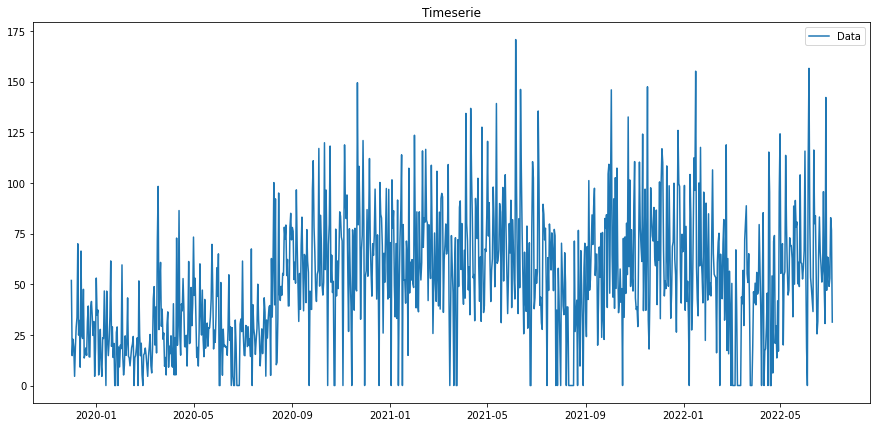

Timeseries loaded ... 0 s
Decomposition loaded ... 0 s


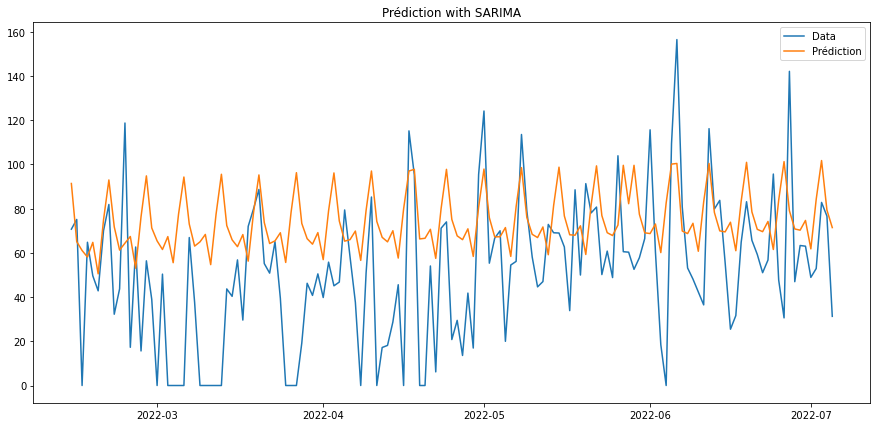

0.24316573651804094
Base Model loaded ... 66 s


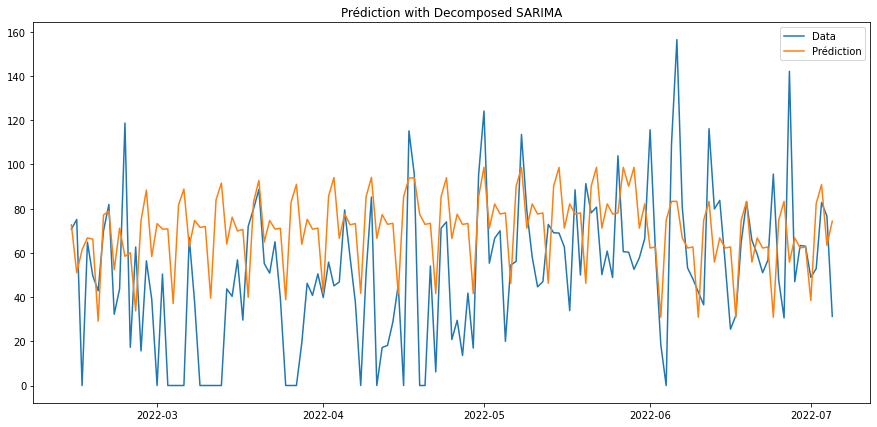

0.24769582404010634
Base Decomp Model loaded ... 16 s
Filtring time ... 0 s


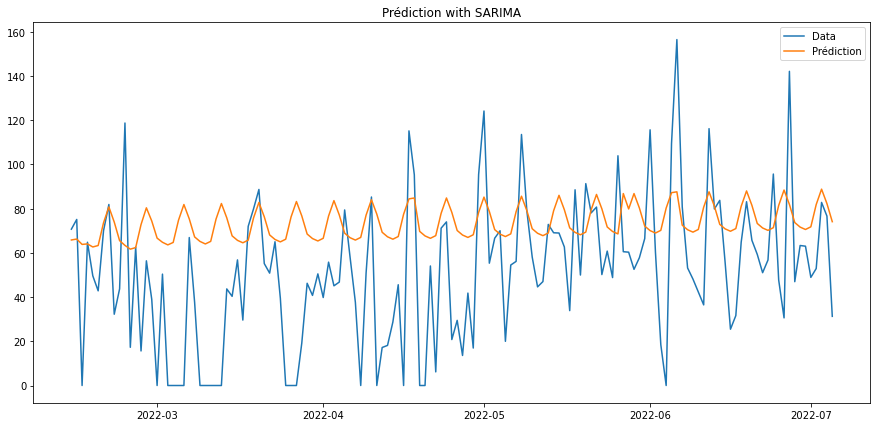

0.24147449159590262
Filtred Model loaded ... 26 s


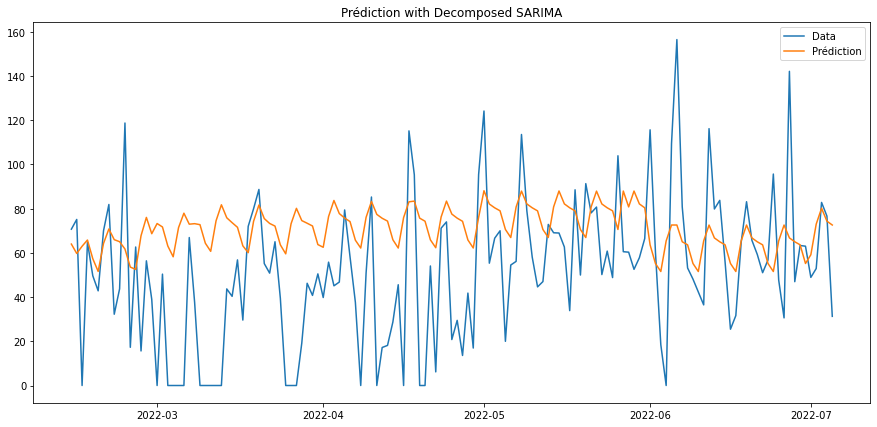

0.2400763199192785
Filtred Decomp Model loaded ... 54 s


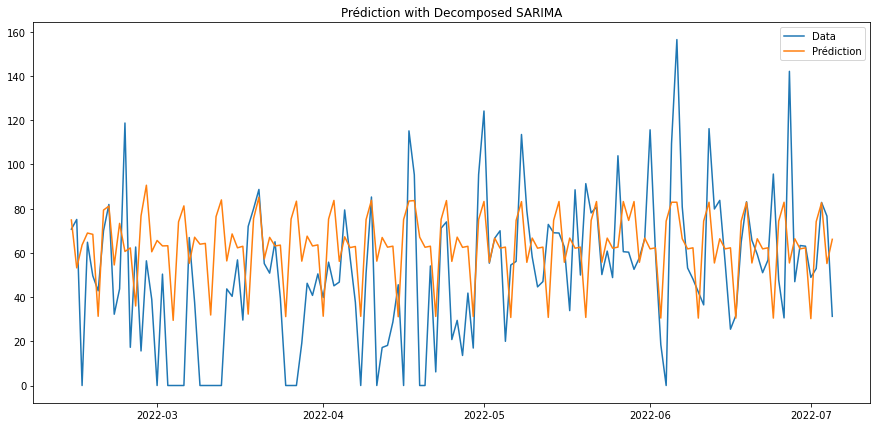

0.22363782227923876
Neural Decomp Model loaded ... 14 s
                     Time     Error
Base            66.538767  0.243166
Base Decomp     16.915821  0.247696
Filtred         26.554882  0.241474
Filtred Decomp  54.376230  0.240076
Neural Decomp   14.558649  0.223638
base: {'time': 66.53876733779907, 'error': 0.981711086411647, 'time best': 0}
base decomp: {'time': 16.915821075439453, 'error': 1.0, 'time best': 0}
filtred: {'time': 26.554881811141968, 'error': 0.9748831758940095, 'time best': 0}
filtred decomp: {'time': 54.376230239868164, 'error': 0.9692384635455376, 'time best': 0}
neural: {'time': 14.558648824691772, 'error': 0.9028728003223334, 'time best': 0.07350499782417974}
         201


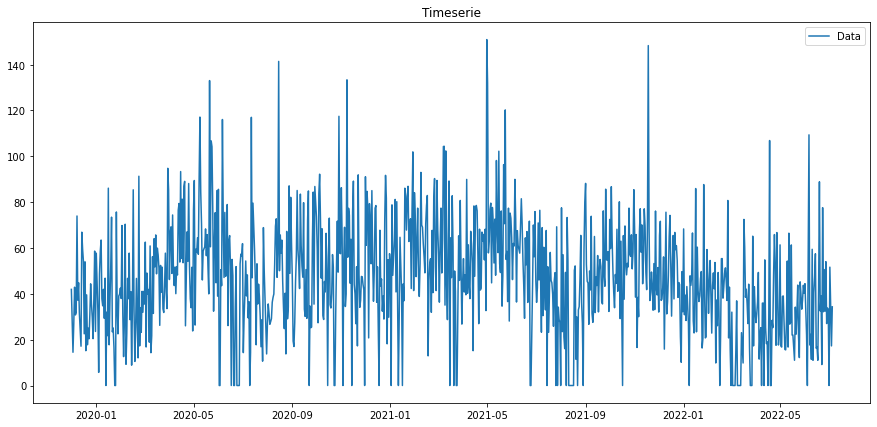

Timeseries loaded ... 0 s
Decomposition loaded ... 0 s


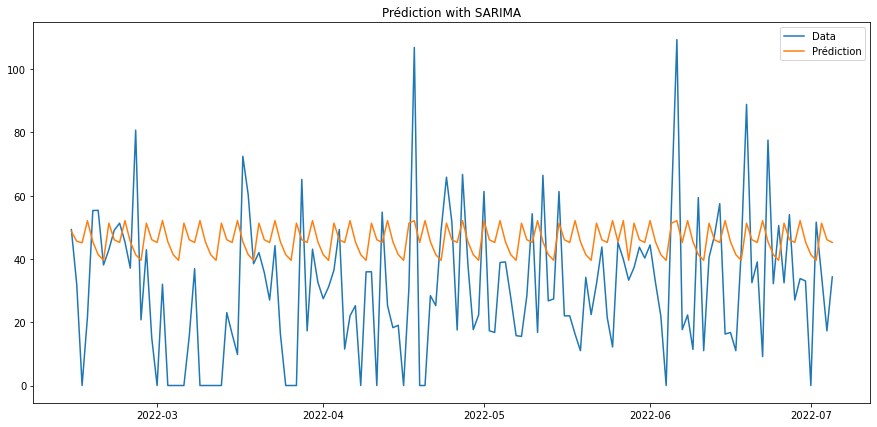

0.23997156957401425
Base Model loaded ... 20 s


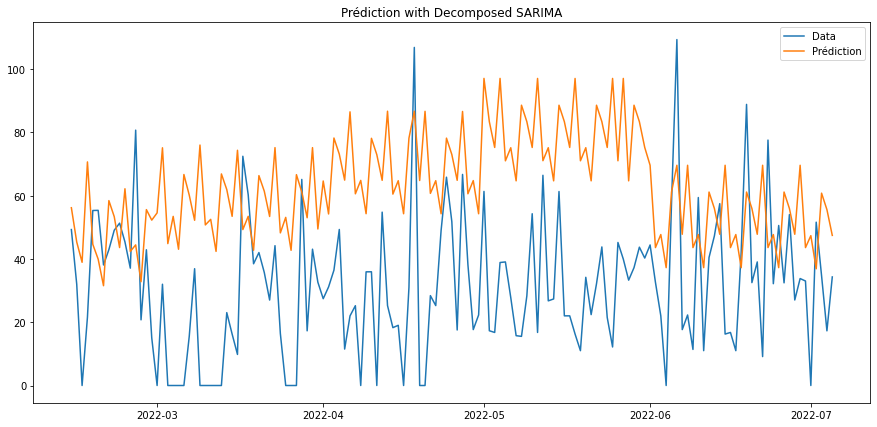

0.3731829740184333
Base Decomp Model loaded ... 27 s
Filtring time ... 0 s


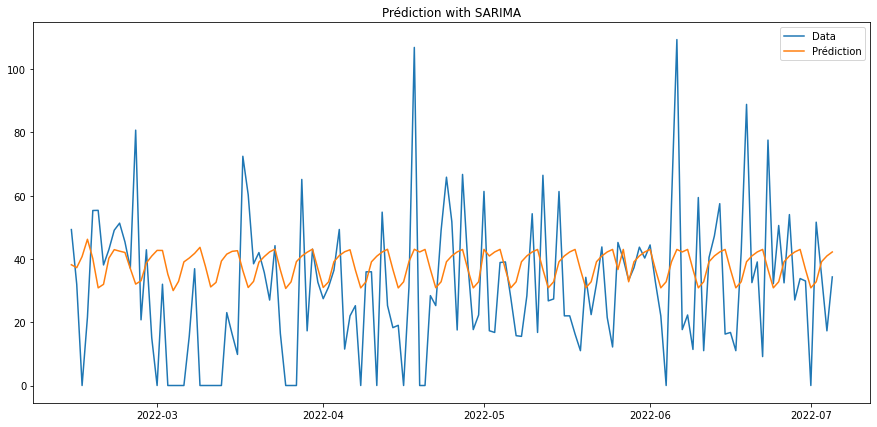

0.20924948806314522
Filtred Model loaded ... 51 s


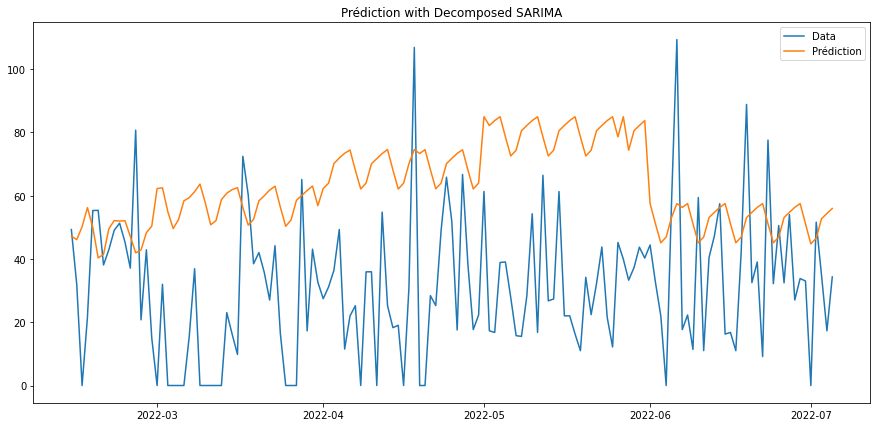

0.36848052041051615
Filtred Decomp Model loaded ... 54 s


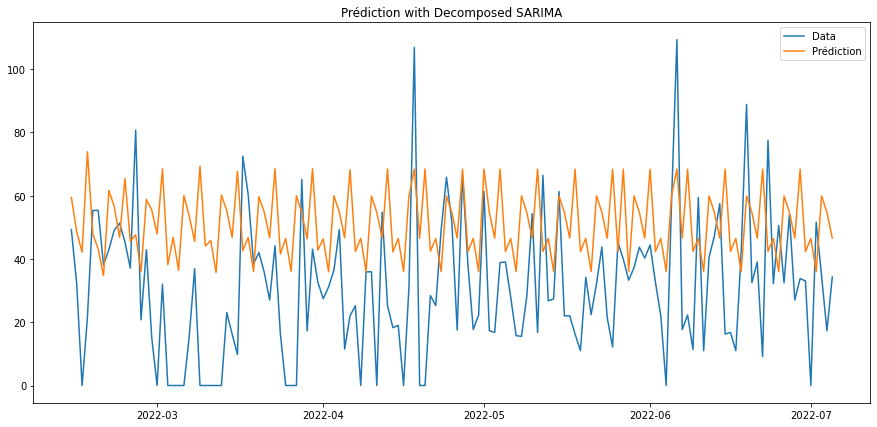

0.2768004856012716
Neural Decomp Model loaded ... 26 s
                     Time     Error
Base            20.432618  0.239972
Base Decomp     27.801992  0.373183
Filtred         51.535074  0.209249
Filtred Decomp  54.521824  0.368481
Neural Decomp   26.949548  0.276800
base: {'time': 86.97138547897339, 'error': 1.6247510595111723, 'time best': 0}
base decomp: {'time': 44.71781277656555, 'error': 2.0, 'time best': 0}
filtred: {'time': 78.0899555683136, 'error': 1.535598703212813, 'time best': 0.1468203425262289}
filtred decomp: {'time': 108.89805436134338, 'error': 1.9566375306645942, 'time best': 0}
neural: {'time': 41.50819659233093, 'error': 1.6446014023019058, 'time best': 0.07350499782417974}
         202
Empty
         203


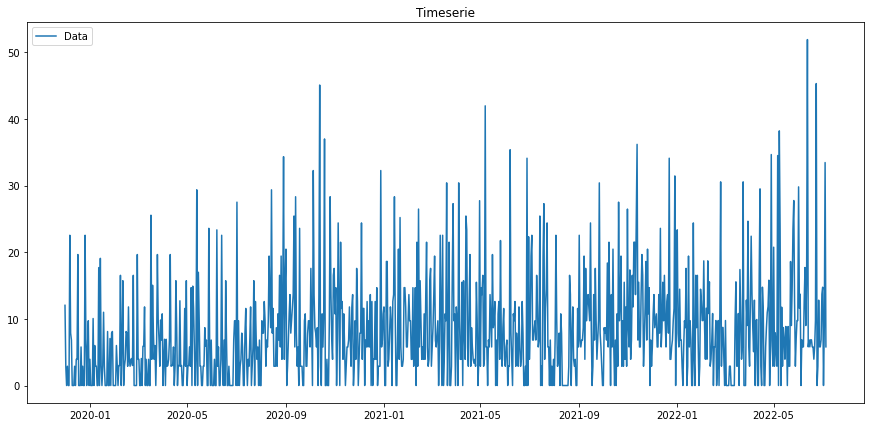

Timeseries loaded ... 0 s
Decomposition loaded ... 0 s


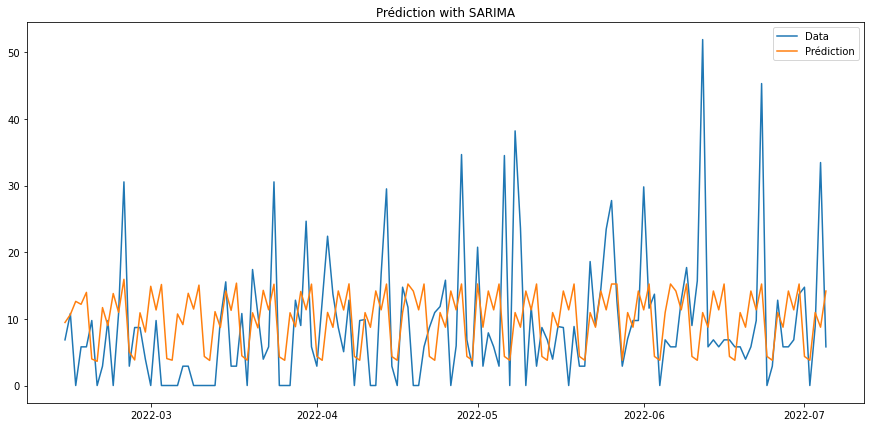

0.18500735592652603
Base Model loaded ... 17 s


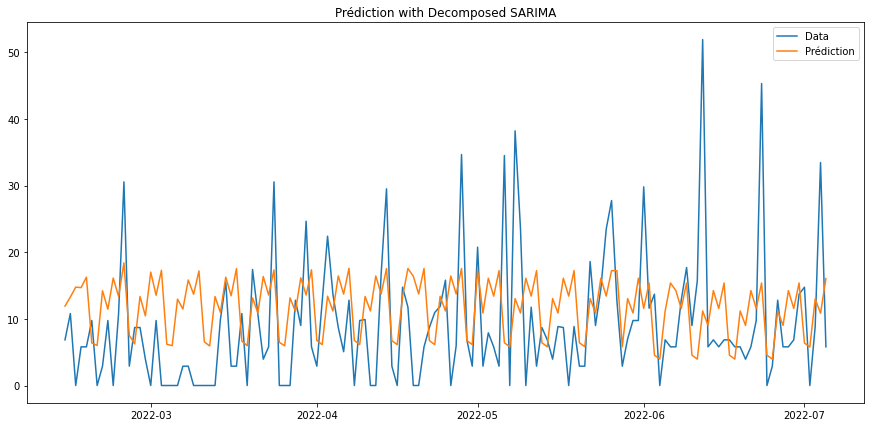

0.19314959931052259
Base Decomp Model loaded ... 30 s
Filtring time ... 0 s


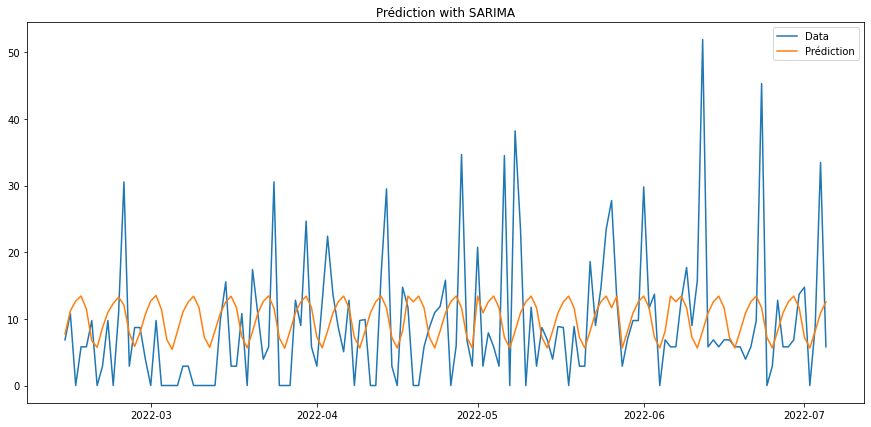

0.18573980670033058
Filtred Model loaded ... 51 s


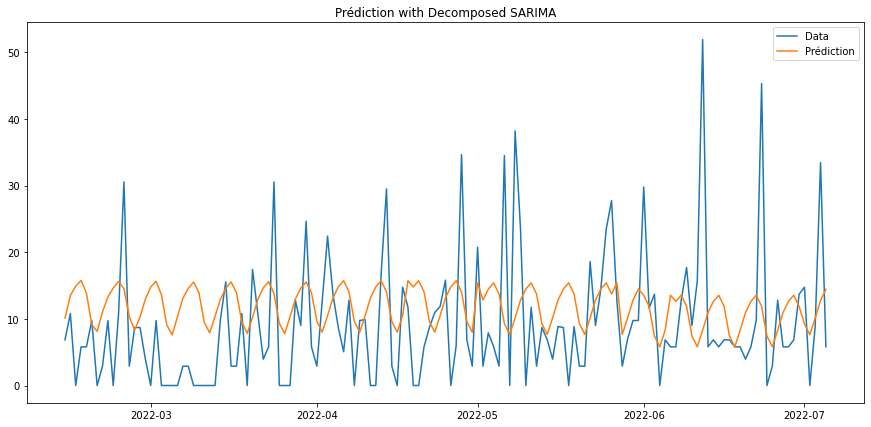

0.1940140171460494
Filtred Decomp Model loaded ... 52 s


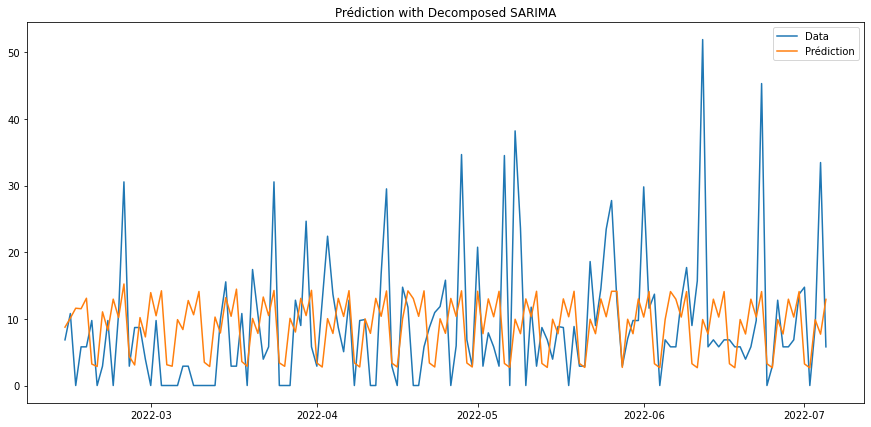

0.18430832957779042
Neural Decomp Model loaded ... 28 s
                     Time     Error
Base            17.910213  0.185007
Base Decomp     30.384770  0.193150
Filtred         51.562661  0.185740
Filtred Decomp  52.109942  0.194014
Neural Decomp   28.671787  0.184308
base: {'time': 104.88159894943237, 'error': 2.5783283249479094, 'time best': 0}
base decomp: {'time': 75.10258293151855, 'error': 2.995544559881588, 'time best': 0}
filtred: {'time': 129.65261673927307, 'error': 2.4929512153280062, 'time best': 0.1468203425262289}
filtred decomp: {'time': 161.0079960823059, 'error': 2.9566375306645942, 'time best': 0}
neural: {'time': 70.17998313903809, 'error': 2.5945756994633693, 'time best': 0.07729769862254798}
         204
Empty
         205
Empty
         206
Empty
         207


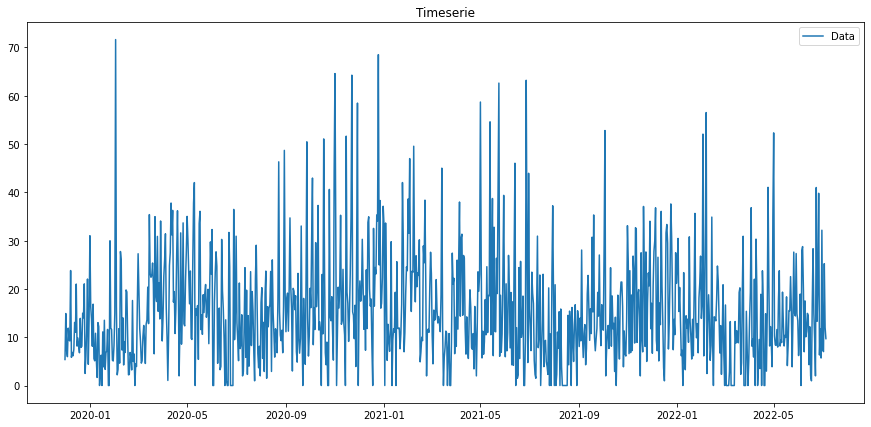

Timeseries loaded ... 0 s
Decomposition loaded ... 0 s


In [ ]:
baseStats          = {"time":0, "error":0, "time best":0}
basedecompStats    = {"time":0, "error":0, "time best":0}
filtredStats       = {"time":0, "error":0, "time best":0}
filtreddecompStats = {"time":0, "error":0, "time best":0}
neuralStats        = {"time":0, "error":0, "time best":0}

best_models = {}

tot_error = 0

for key in R:
    print("=====================\n         " + str(key) + "\n=====================")
    
    if len(all_df[key].values) < 1000:
        print("Empty")
        continue
        
    start = time()
    ts_univers = get_timeseries(all_df[key], TEMPS_DETAIL, RECETTE_DETAIL, show_plot=True)
    print("Timeseries loaded ...", int(time()-start), "s")
    
    DF_stats = get_forecast(ts_univers, TEMPS_DETAIL, RECETTE_DETAIL, alpha, season, method = METHOD, show_plot=True)
    
    print(DF_stats)
    
    errors = DF_stats.values[:,1]
    max_errors = max(errors)
    min_errors = min(errors)
    
    baseStats["time"] += DF_stats.values[0][0]
    if DF_stats.values[0][1]:
        baseStats["error"] += DF_stats.values[0][1]/max_errors
    if DF_stats.values[0][1] == min_errors:
        best_models[key] = ['base', DF_stats.values[0][1], DF_stats.values[0][0]]
        baseStats["time best"] += min([
            (val/DF_stats.values[0][1]-1) if val != DF_stats.values[0][1] else 1 for val in errors
        ])
    
    basedecompStats["time"] += DF_stats.values[1][0] 
    if DF_stats.values[1][1]:
        basedecompStats["error"] += DF_stats.values[1][1]/max_errors
    if DF_stats.values[1][1] == min_errors:
        best_models[key] = ['baseD', DF_stats.values[1][1], DF_stats.values[1][0]]
        basedecompStats["time best"] +=min([
            (val/DF_stats.values[1][1]-1) if val != DF_stats.values[1][1] else 1 for val in errors
        ])
    
    filtredStats["time"] += DF_stats.values[2][0]
    if DF_stats.values[2][1]:
        filtredStats["error"] += DF_stats.values[2][1]/max_errors
    if DF_stats.values[2][1] == min_errors:
        best_models[key] = ['filtred', DF_stats.values[2][1], DF_stats.values[2][0]]
        filtredStats["time best"] += min([
            (val/DF_stats.values[2][1]-1) if val != DF_stats.values[2][1] else 1 for val in errors
        ])
    
    filtreddecompStats["time"] += DF_stats.values[3][0]
    if DF_stats.values[3][1]:
        filtreddecompStats["error"] += DF_stats.values[3][1]/max_errors
    if DF_stats.values[3][1] == min_errors:
        best_models[key] = ['filtredD', DF_stats.values[3][1], DF_stats.values[3][0]]
        filtreddecompStats["time best"] += min([
            (val/DF_stats.values[3][1]-1) if val != DF_stats.values[3][1] else 1 for val in errors
        ])
    
    neuralStats["time"] += DF_stats.values[4][0]
    if DF_stats.values[4][1]:
        neuralStats["error"] += DF_stats.values[4][1]/max_errors
    if DF_stats.values[4][1] == min_errors:
        best_models[key] = ['neural', DF_stats.values[4][1], DF_stats.values[4][0]]
        neuralStats["time best"] += min([
            (val/DF_stats.values[4][1]-1) if val != DF_stats.values[4][1] else 1 for val in errors
        ])
    
    tot_error += min_errors/max_errors
    print("base:", baseStats)
    print("base decomp:",basedecompStats)
    print("filtred:",filtredStats)
    print("filtred decomp:",filtreddecompStats)
    print("neural:",neuralStats)
    
N = len(R)
print("Total Error : ", tot_error)

baseStats["time"] /= N
baseStats["error"] /= N

basedecompStats["time"] /= N
basedecompStats["error"] /= N

filtredStats["time"] /= N
filtredStats["error"] /= N

filtreddecompStats["time"] /= N
filtreddecompStats["error"] /= N

neuralStats["time"] /= N
neuralStats["error"] /= N

print("base:", baseStats)
print("base decomp:",basedecompStats)
print("filtred:",filtredStats)
print("filtred decomp:",filtreddecompStats)
print("neural:",neuralStats)

print(best_models)

In [ ]:
print(best_models)

In [53]:
conn = engine.connect()

for key,val in best_models.items():
    if val[1]>.25:
        continue
        
    if val[0] == 'base':
        libelle = 1
    elif val[0] == 'baseD':
        libelle = 2
    elif val[0] == 'filtred':
        libelle = 3
    elif val[0] == 'filtredD':
        libelle = 4
    elif val[0] == 'neural':
        libelle = 5
    else:
        print('error for ', key, val)
        continue
    
    sql_cmd = '''INSERT INTO ['''+DB+'''].[PML].[Best_Model] 
    ([Best_Model.MODEL.KEY],
    [Best_Model.UNIVERS.KEY],
    [Best_Model.NRMSD],
    [Best_Model.Time_to_run_in_second])
    VALUES ('''+str(libelle)+''', '''+str(key)+''', '''+str(round(val[1],2))+''', '''+str(round(val[2],2))+''')'''
    
#     print(sql_cmd)
    conn.execute(sql_cmd)
    
conn.close()

INSERT INTO [Delitraiteur_qualif_bacpac.bacpac_20220706].[PML].[Best_Model] 
    ([Best_Model.MODEL.KEY],
    [Best_Model.UNIVERS.KEY],
    [Best_Model.NRMSD],
    [Best_Model.Time_to_run_in_second])
    VALUES (3, 100, 0.21, 39.9)
INSERT INTO [Delitraiteur_qualif_bacpac.bacpac_20220706].[PML].[Best_Model] 
    ([Best_Model.MODEL.KEY],
    [Best_Model.UNIVERS.KEY],
    [Best_Model.NRMSD],
    [Best_Model.Time_to_run_in_second])
    VALUES (5, 101, 0.2, 18.29)
INSERT INTO [Delitraiteur_qualif_bacpac.bacpac_20220706].[PML].[Best_Model] 
    ([Best_Model.MODEL.KEY],
    [Best_Model.UNIVERS.KEY],
    [Best_Model.NRMSD],
    [Best_Model.Time_to_run_in_second])
    VALUES (5, 102, 0.19, 14.88)
INSERT INTO [Delitraiteur_qualif_bacpac.bacpac_20220706].[PML].[Best_Model] 
    ([Best_Model.MODEL.KEY],
    [Best_Model.UNIVERS.KEY],
    [Best_Model.NRMSD],
    [Best_Model.Time_to_run_in_second])
    VALUES (3, 107, 0.19, 20.62)
INSERT INTO [Delitraiteur_qualif_bacpac.bacpac_20220706].[PML].[Best_M

INSERT INTO [Delitraiteur_qualif_bacpac.bacpac_20220706].[PML].[Best_Model] 
    ([Best_Model.MODEL.KEY],
    [Best_Model.UNIVERS.KEY],
    [Best_Model.NRMSD],
    [Best_Model.Time_to_run_in_second])
    VALUES (5, 182, 0.13, 37.78)
INSERT INTO [Delitraiteur_qualif_bacpac.bacpac_20220706].[PML].[Best_Model] 
    ([Best_Model.MODEL.KEY],
    [Best_Model.UNIVERS.KEY],
    [Best_Model.NRMSD],
    [Best_Model.Time_to_run_in_second])
    VALUES (1, 183, 0.13, 50.54)
INSERT INTO [Delitraiteur_qualif_bacpac.bacpac_20220706].[PML].[Best_Model] 
    ([Best_Model.MODEL.KEY],
    [Best_Model.UNIVERS.KEY],
    [Best_Model.NRMSD],
    [Best_Model.Time_to_run_in_second])
    VALUES (2, 186, 0.13, 14.49)
INSERT INTO [Delitraiteur_qualif_bacpac.bacpac_20220706].[PML].[Best_Model] 
    ([Best_Model.MODEL.KEY],
    [Best_Model.UNIVERS.KEY],
    [Best_Model.NRMSD],
    [Best_Model.Time_to_run_in_second])
    VALUES (5, 187, 0.17, 19.32)
INSERT INTO [Delitraiteur_qualif_bacpac.bacpac_20220706].[PML].[Best

In [54]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~28769secondes


In [55]:
def get_prediction(ts_main, model, day_predicted, TEMPS_DETAIL, RECETTE_DETAIL, season = 7, method = METHOD, show_plot=True):
    start = time()
    
    alpha = 0.999
    
    ts_month, ts_monthless = decompose_series(ts_main, False)

    ts_filtred       = get_filtred(ts_main)
    ts_day_filtred   = get_filtred(ts_monthless)
    
    _, val_main = train_test_split(ts_main,test_size = 1-alpha, shuffle = False)
    
    
    if model == 'base':
        # Création du modèle prédictif 
        (model_base, _, _) = base_SARIMA(ts_main, alpha, season, method, False)
        time_base = time()-start
        print("Base Model loaded ...", int(time_base), "s")
        
        # Génération de prédiction
        pred = model_base.predict(n_periods = day_predicted)
        pred = pd.Series(data  = pred, 
                         index = [ts_main.index[-1] + timedelta(days = i+1) for i in range(day_predicted)])

    
    elif model == 'baseD':
        if len(ts_month) < 24:
            print("To less data sent, try to load more data")
            return
            
        # Création du modèle prédictif 
        (model_base_monthless, 
         model_base_month, _, _) = decomp_SARIMA(val_main, ts_month, ts_monthless, alpha, season, method, False)
        time_base_decomp = time()-start
        print("Base Decomp Model loaded ...", int(time_base_decomp), "s")
        
        # Génération de prédiction
        pred_monthless = model_base_monthless.predict(n_periods = day_predicted)
        pred_monthless = pd.Series(data  = pred_monthless, 
                         index = [ts_main.index[-1] + timedelta(days = i+1) for i in range(day_predicted)])
        
        N_month_predicted = int(day_predicted/28)+2
        pred_month = model_base_month.predict(n_periods = N_month_predicted)
        pred_month = pd.Series(data  = pred_month, 
                               index = [ts_month.index[-1] + relativedelta(months = i) for i in range(N_month_predicted)])
        
        pred  = pred_monthless.copy()
        mean_pred = sum(pred_monthless.values)/len(pred_monthless)
        for k in pred.index:
            if not date(k.year, k.month, 1) in pred_month.index:
                print("ERROR CHECK ALGO")
                return
            pred[k] += pred_month[date(k.year, k.month, 1)] - mean_pred

    
    
    elif model == 'filtred':
        # Création du modèle prédictif 
        (model_filtred,  _, _) = base_SARIMA(ts_filtred, alpha, season, method, False, val_main)
        time_filtred = time()-start
        print("Filtred Model loaded ...", int(time_filtred), "s")
        
        # Génération de prédiction
        pred = model_filtred.predict(n_periods = day_predicted)
        pred = pd.Series(data  = pred, 
                         index = [ts_main.index[-1] + timedelta(days = i+1) for i in range(day_predicted)])

    
    elif model == 'filtredD':
        if len(ts_month) < 24:
            print("To less data sent, try to load more data")
            return
            
        # Création du modèle prédictif 
        (model_filtred_monthless, 
         model_filtred_month, _, _) = decomp_SARIMA(val_main, ts_month, ts_day_filtred, alpha, season, method, False)
        time_filtred_decomp = time()-start
        print("Filtred Decomp Model loaded ...", int(time_filtred_decomp), "s")

        # Génération de prédiction        
        pred_monthless = model_filtred_monthless.predict(n_periods = day_predicted)
        pred_monthless = pd.Series(data  = pred_monthless, 
                         index = [ts_main.index[-1] + timedelta(days = i+1) for i in range(day_predicted)])
        
        N_month_predicted = int(day_predicted/28)+2
        pred_month = model_filtred_month.predict(n_periods = N_month_predicted)
        pred_month = pd.Series(data  = pred_month, 
                               index = [ts_month.index[-1] + relativedelta(months = i) for i in range(N_month_predicted)])
        
        pred  = pred_monthless.copy()
        mean_pred = sum(pred_monthless.values)/len(pred_monthless)
        for k in pred.index:
            if not date(k.year, k.month, 1) in pred_month.index:
                print("ERROR CHECK ALGO")
                return
            pred[k] += pred_month[date(k.year, k.month, 1)] - mean_pred


        
    elif model == 'neural':
        if len(ts_month) < 24:
            print("To less data sent, try to load more data")
            return
            
        # Création du modèle prédictif 
        (model_neural_monthless, 
         model_neural_month, _, _) = neural_decomp(val_main, ts_month, ts_monthless, alpha, season, method, False)
        time_neural = time()-start
        print("Neural Decomp Model loaded ...", int(time_neural), "s")
                
        # Génération de prédiction
        pred_monthless = model_neural_monthless.predict(n_periods = day_predicted)
        pred_monthless = pd.Series(data  = pred_monthless, 
                         index = [ts_main.index[-1] + timedelta(days = i+1) for i in range(day_predicted)])
        
        N_month_predicted = int(day_predicted/28)+2
        
        scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
        dataset = scaler.fit_transform([[v] for v in ts_month.values])
        train , _ = train_test_split(dataset,test_size = 1-alpha, shuffle = False)
        trainX, _ = to_sequences(train,  3)
        start = trainX[-1]
        pred_month = []

        N_val = N_month_predicted
        for i in range(N_val):
            p = model_neural_month.predict(np.array([[start]]), verbose = 0)[0]

            start = np.append(start[1:],p)
            pred_month  = np.append(pred_month, [p])

        pred_month = scaler.inverse_transform([[v] for v in pred_month])
        pred_month = pd.Series(data = pred_month[:,0], 
                               index = [ts_month.index[-1] + relativedelta(months = i) for i in range(N_month_predicted)])

        
        pred  = pred_monthless.copy()
        mean_pred = sum(pred_monthless.values)/len(pred_monthless)
        for k in pred.index:
            if not date(k.year, k.month, 1) in pred_month.index:
                print("ERROR CHECK ALGO")
                return
            pred[k] += pred_month[date(k.year, k.month, 1)] - mean_pred

    if show_plot:
        ts_main.tail(2*day_predicted).plot(label="Data",legend=True, figsize=(15,7))
        pred.plot(label="Prédiction" ,legend=True)
        plt.title("Prédiction with Decomposed SARIMA")
        plt.show()
        
        
    else:
        print("Model Name Error : Choose between 'base', 'baseD', 'filtred', 'filtredD' or 'neural'")
    
    return pred

         100
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,2)(1,1,1)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\k.dubrulle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\k.dubrulle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\k.dubrulle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\k.dubrulle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\ProgramData\Anaconda3\lib\site-pa

Filtred Model loaded ... 33 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


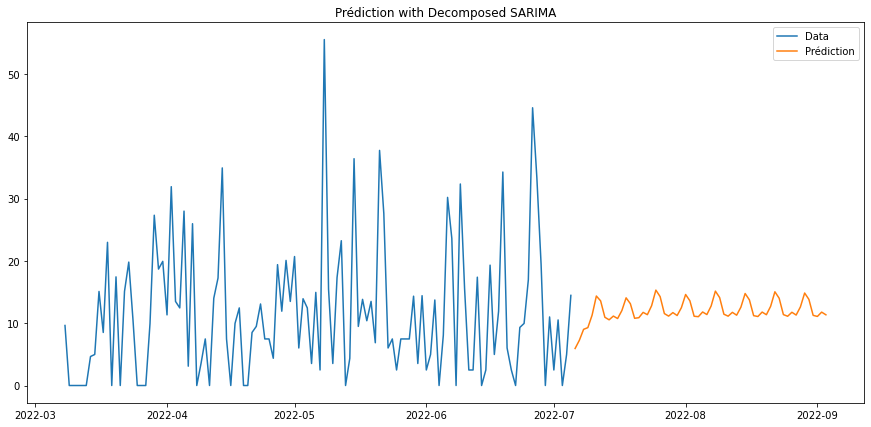

Prediction loaded loaded ... 33 s
         101
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 20 s


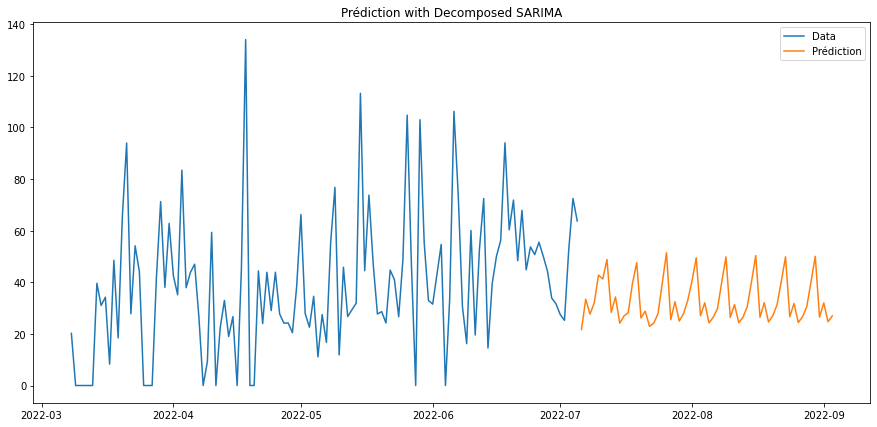

Prediction loaded loaded ... 21 s
         102
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 18 s


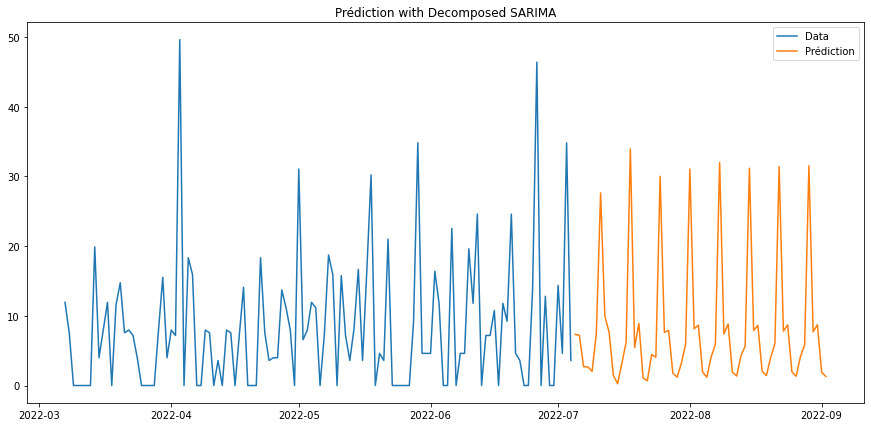

Prediction loaded loaded ... 18 s
         103
No Model loaded
         104
No Model loaded
         105
No Model loaded
         106
No Model loaded
         107
Timeseries loaded ... 0 s
Filtred Model loaded ... 49 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


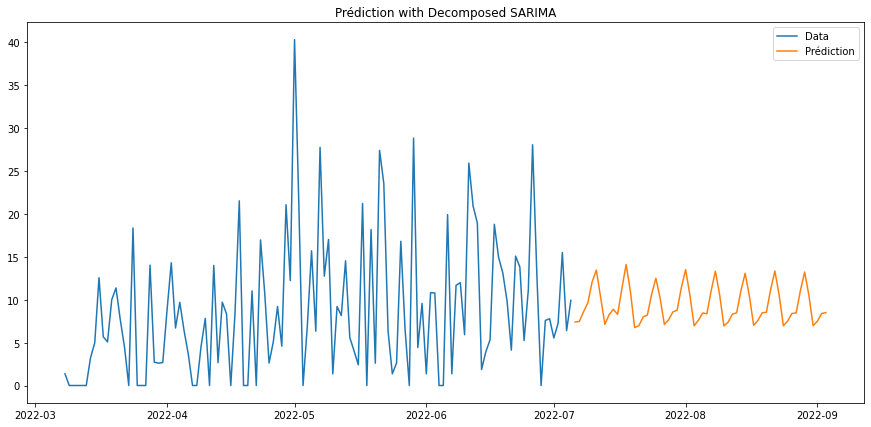

Prediction loaded loaded ... 49 s
         108
No Model loaded
         109
No Model loaded
         110
Timeseries loaded ... 0 s
Base Model loaded ... 23 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


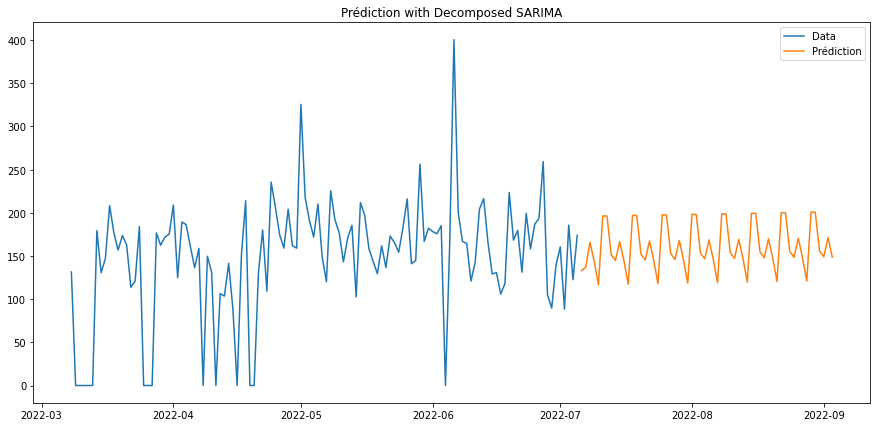

Prediction loaded loaded ... 24 s
         111
Timeseries loaded ... 0 s
Base Model loaded ... 14 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


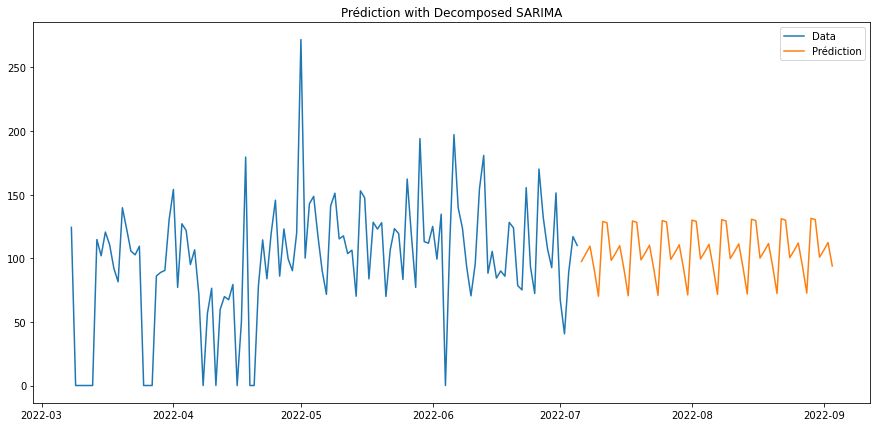

Prediction loaded loaded ... 14 s
         112
Timeseries loaded ... 0 s
Base Model loaded ... 14 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


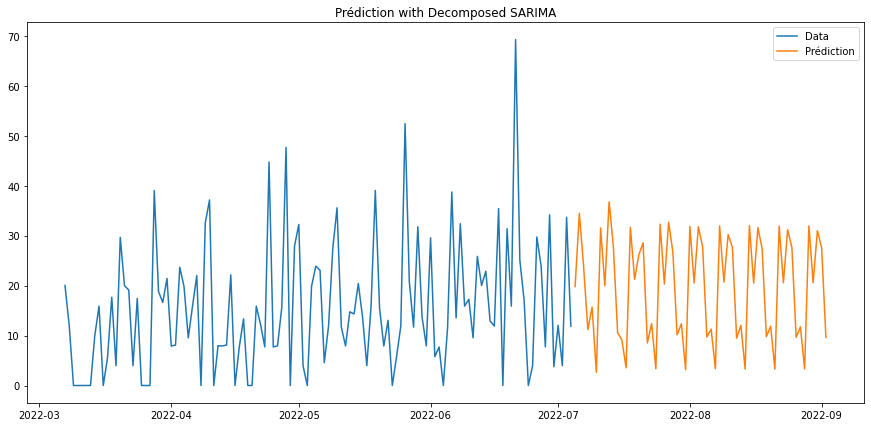

Prediction loaded loaded ... 14 s
         113
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Decomp Model loaded ... 49 s


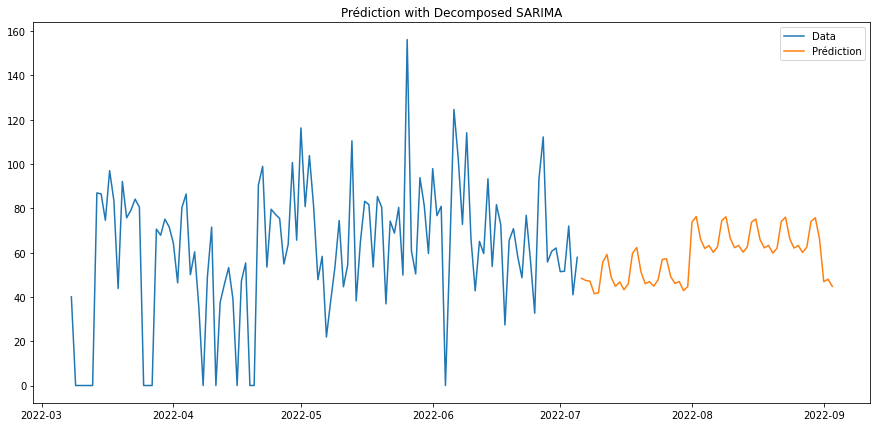

Prediction loaded loaded ... 50 s
         114
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 31 s


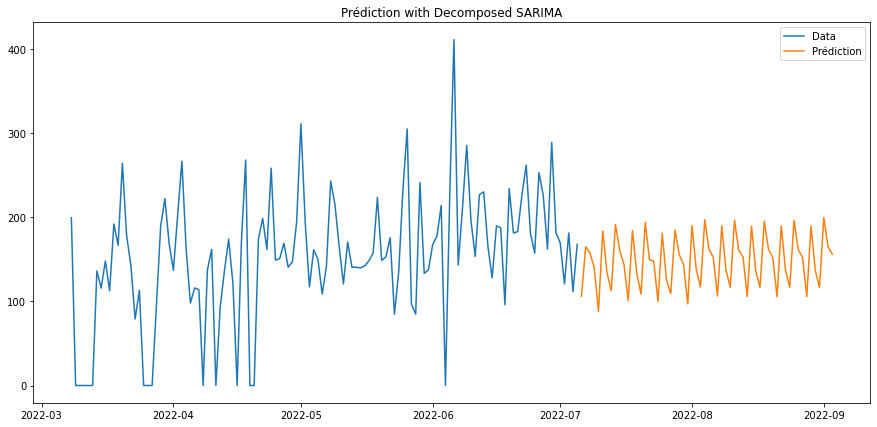

Prediction loaded loaded ... 32 s
         115
Timeseries loaded ... 0 s
Base Model loaded ... 68 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


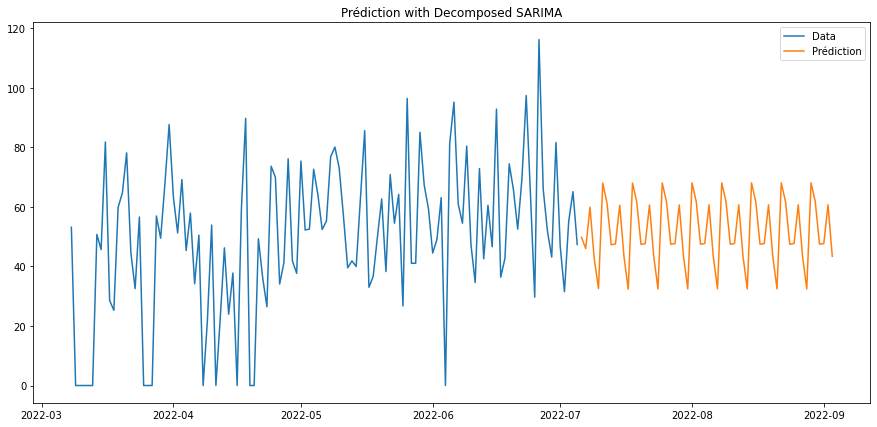

Prediction loaded loaded ... 69 s
         116
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Decomp Model loaded ... 30 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


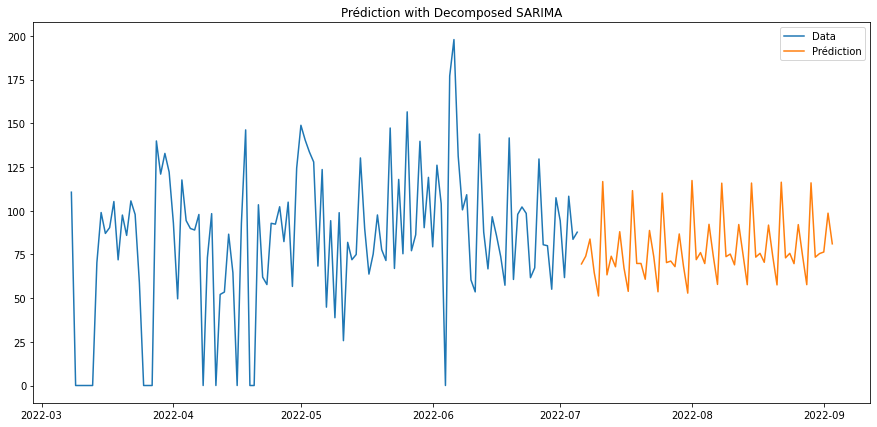

Prediction loaded loaded ... 30 s
         117
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 17 s


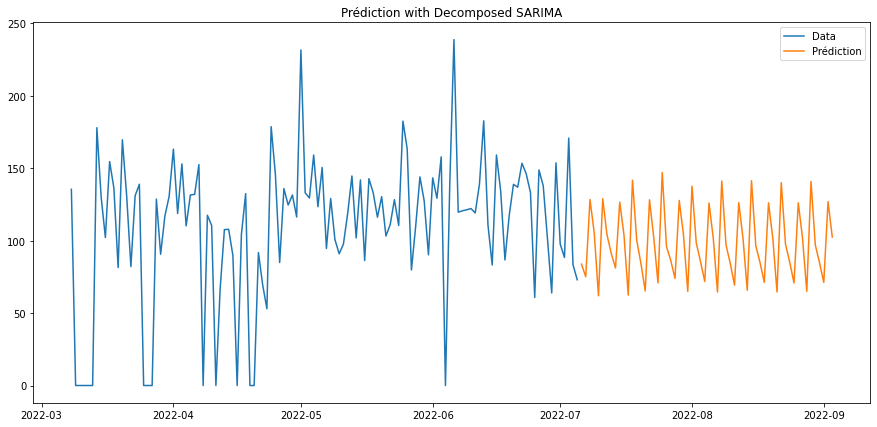

Prediction loaded loaded ... 18 s
         118
No Model loaded
         119
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Decomp Model loaded ... 66 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


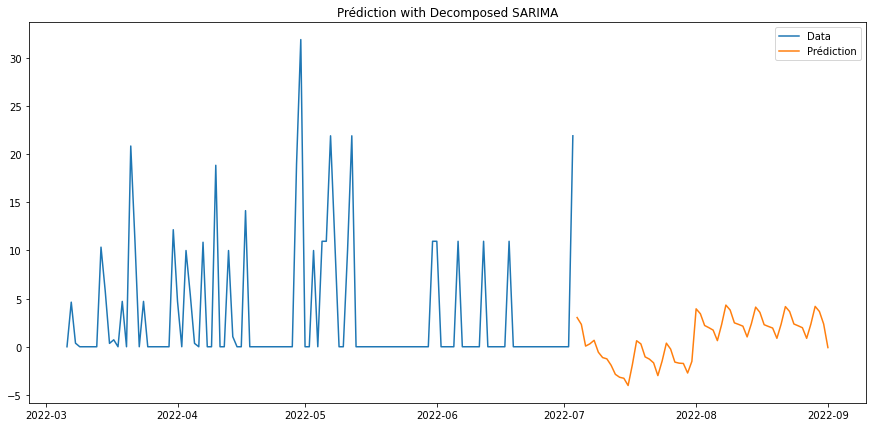

Prediction loaded loaded ... 67 s
         120
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Decomp Model loaded ... 55 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


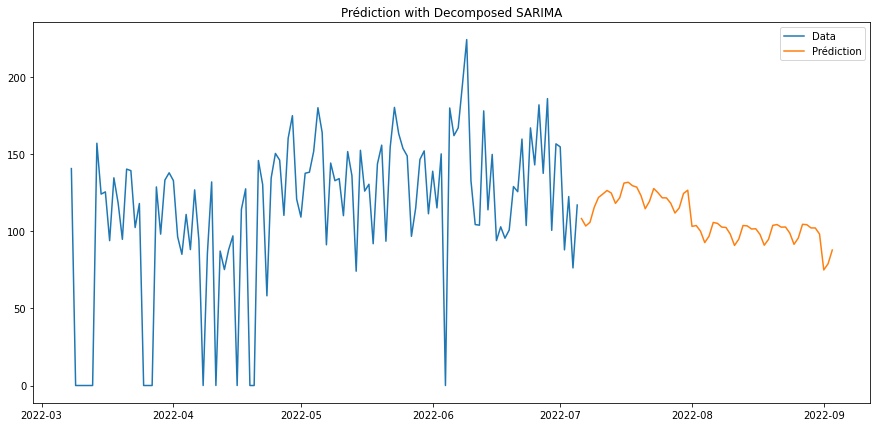

Prediction loaded loaded ... 56 s
         121
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 19 s


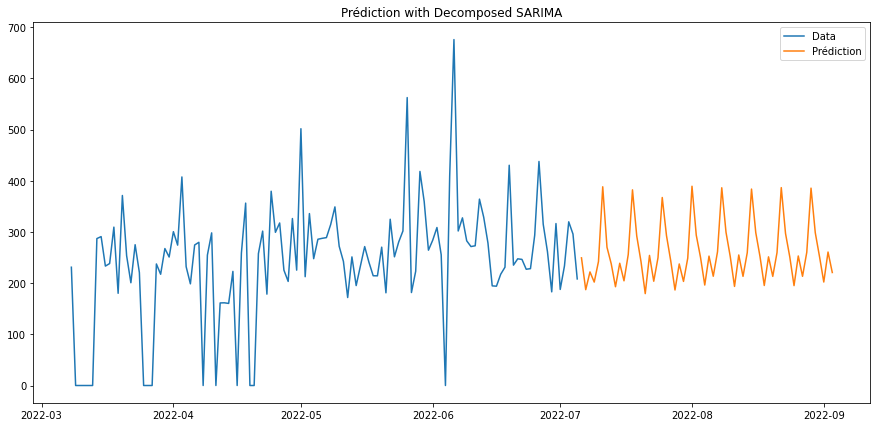

Prediction loaded loaded ... 20 s
         122
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Decomp Model loaded ... 53 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


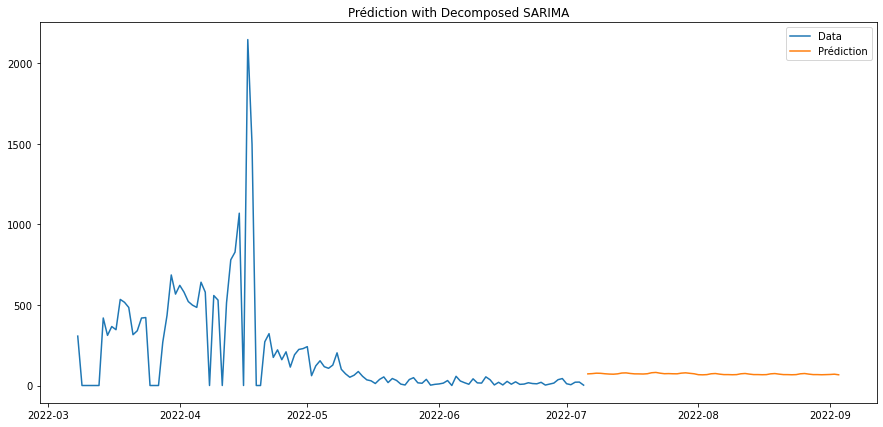

Prediction loaded loaded ... 54 s
         123
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Decomp Model loaded ... 48 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


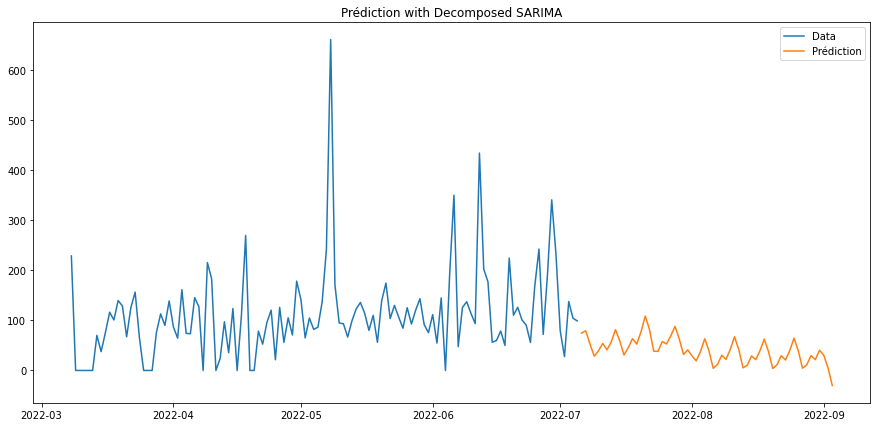

Prediction loaded loaded ... 48 s
         124
Timeseries loaded ... 0 s
Filtred Model loaded ... 83 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


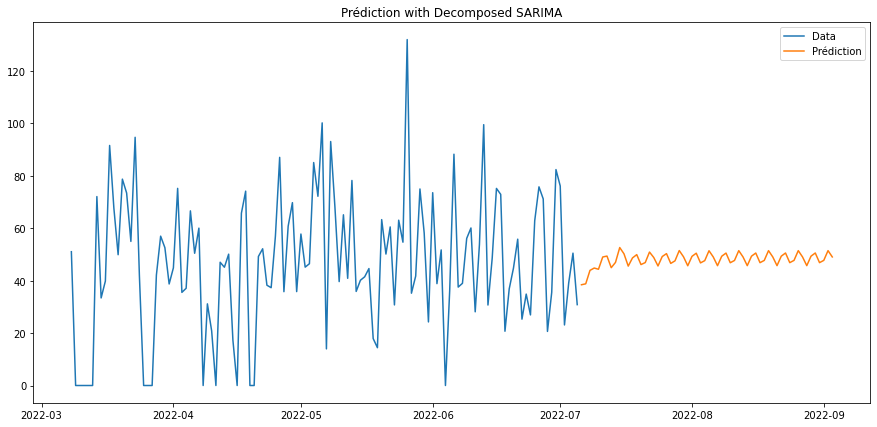

Prediction loaded loaded ... 84 s
         125
No Model loaded
         126
No Model loaded
         127
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 21 s


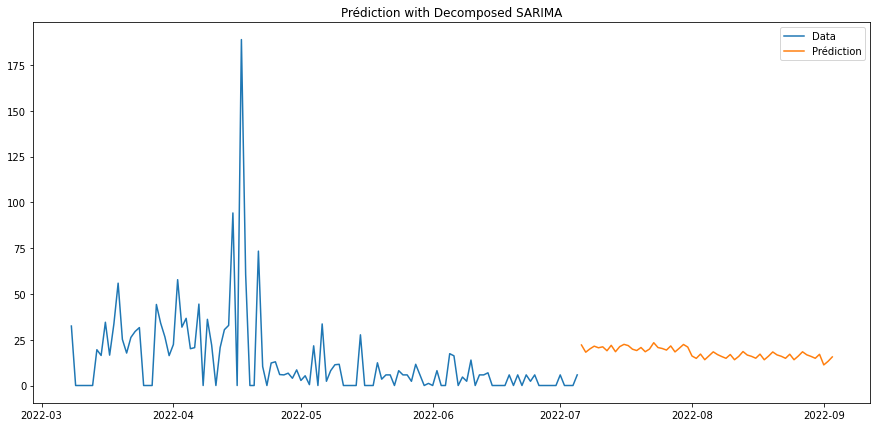

Prediction loaded loaded ... 22 s
         128
Timeseries loaded ... 0 s
Filtred Model loaded ... 37 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


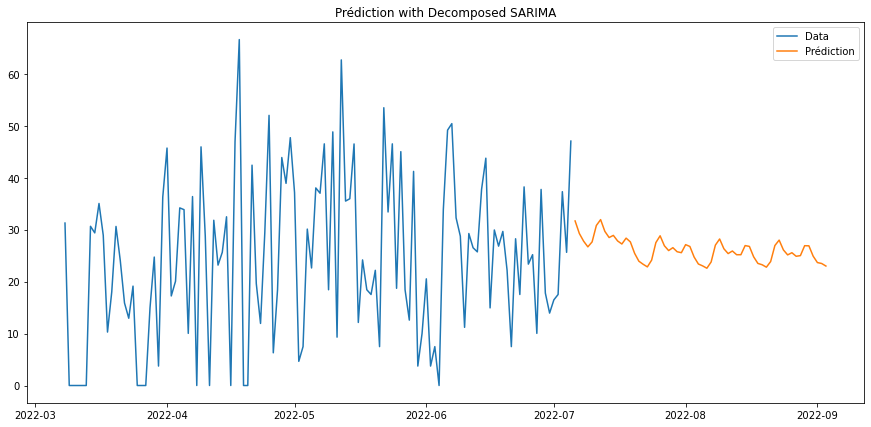

Prediction loaded loaded ... 37 s
         129
No Model loaded
         130
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Decomp Model loaded ... 64 s


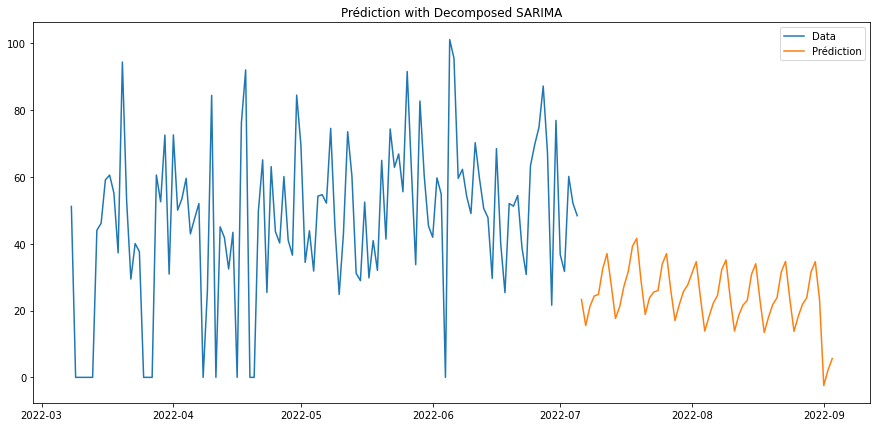

Prediction loaded loaded ... 64 s
         131
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 76 s


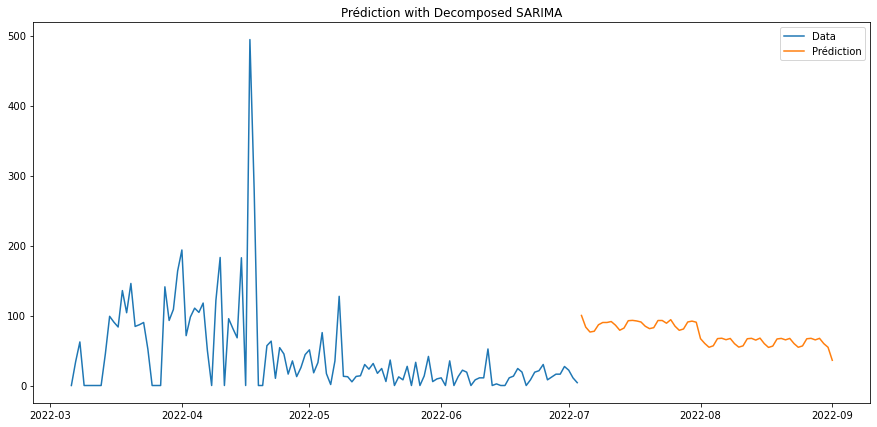

Prediction loaded loaded ... 76 s
         132
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 20 s


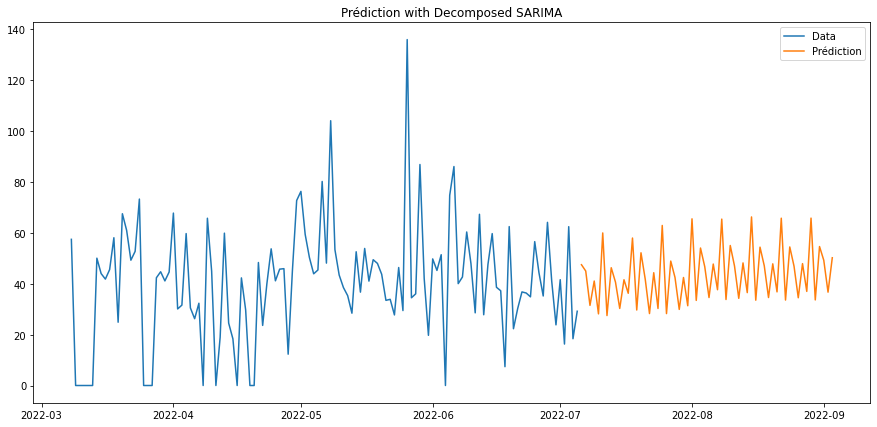

Prediction loaded loaded ... 21 s
         133
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Decomp Model loaded ... 21 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


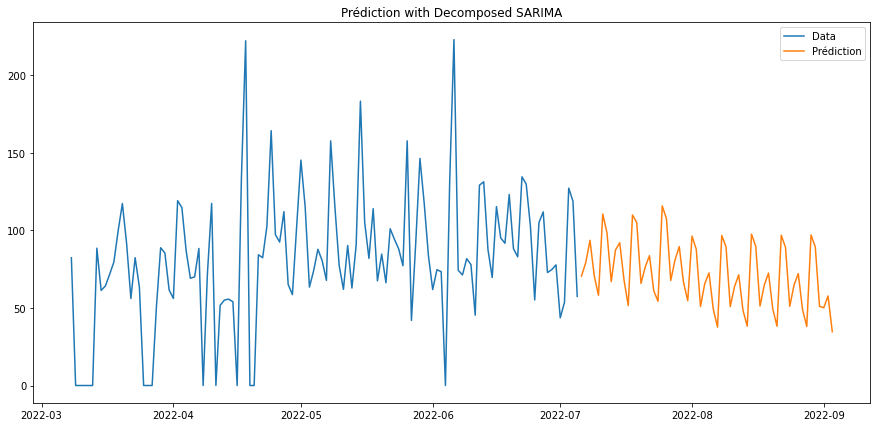

Prediction loaded loaded ... 21 s
         134
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 21 s


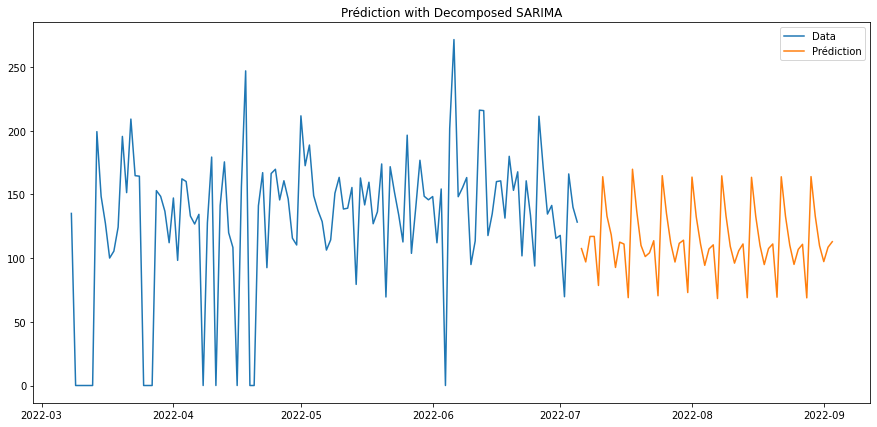

Prediction loaded loaded ... 21 s
         135
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Decomp Model loaded ... 59 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


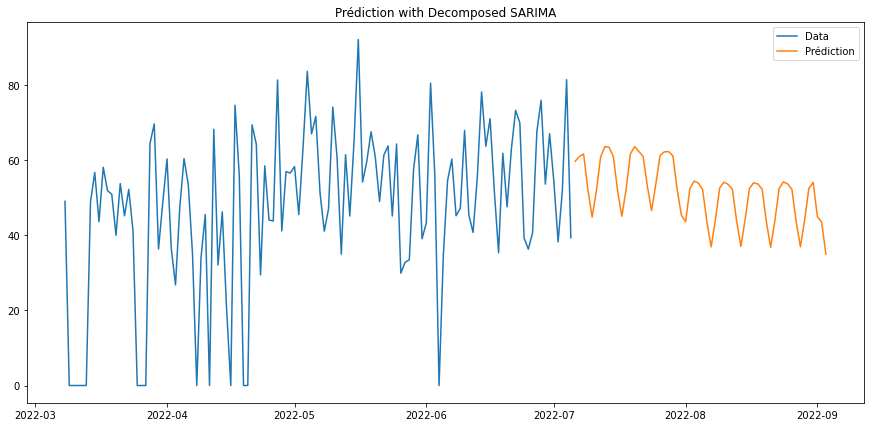

Prediction loaded loaded ... 60 s
         136
Timeseries loaded ... 0 s
Filtred Model loaded ... 56 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


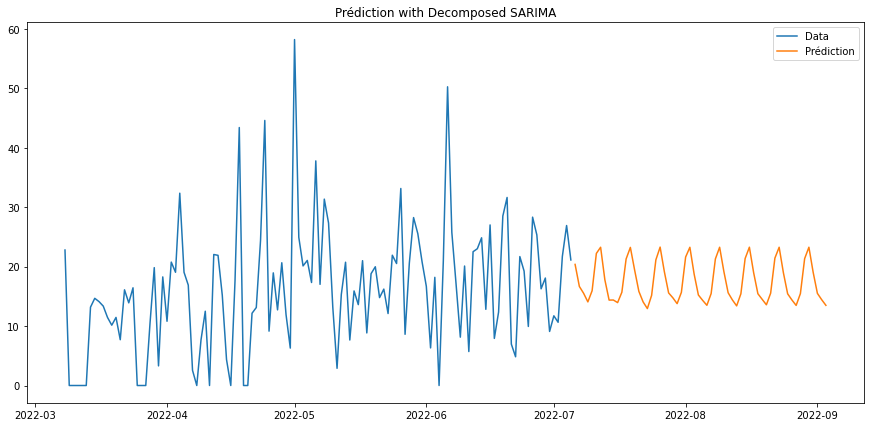

Prediction loaded loaded ... 56 s
         137
Timeseries loaded ... 0 s
Base Model loaded ... 54 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


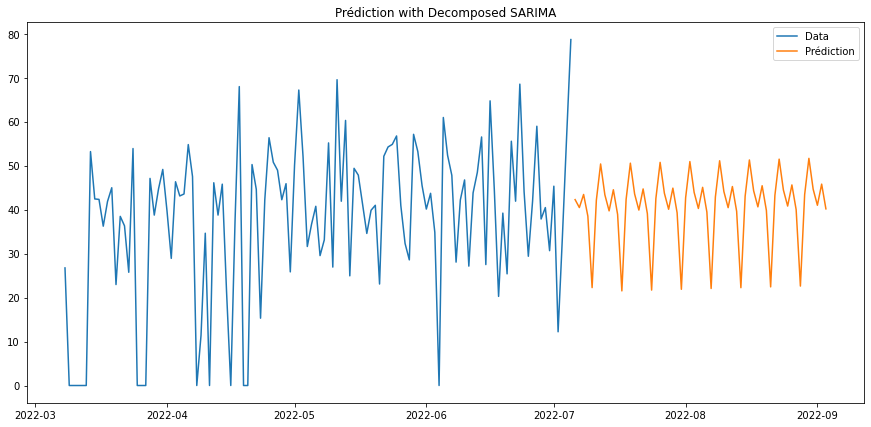

Prediction loaded loaded ... 54 s
         138
No Model loaded
         139
Timeseries loaded ... 0 s
Base Model loaded ... 51 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


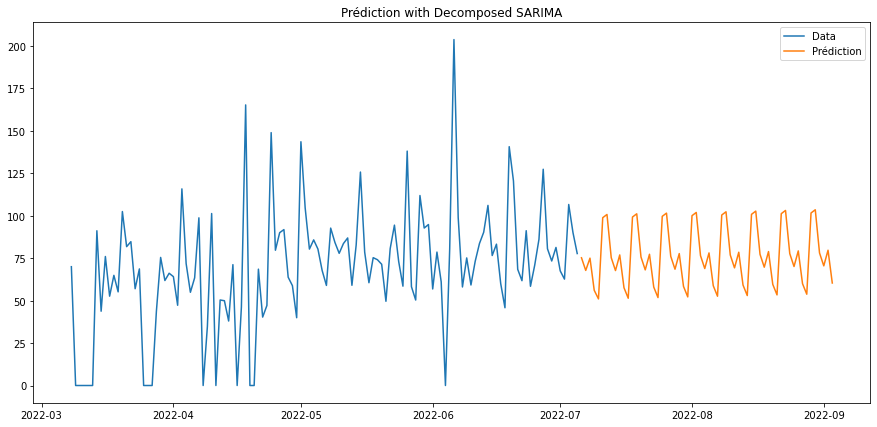

Prediction loaded loaded ... 51 s
         140
Timeseries loaded ... 0 s
Filtred Model loaded ... 46 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


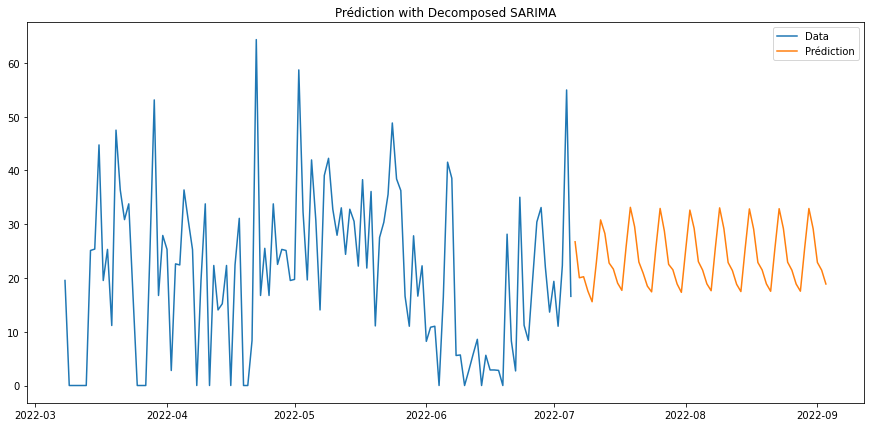

Prediction loaded loaded ... 47 s
         141
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Decomp Model loaded ... 48 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


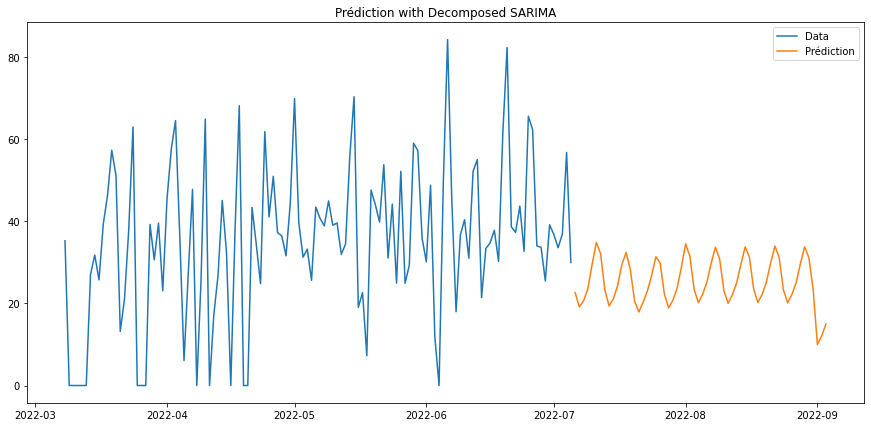

Prediction loaded loaded ... 48 s
         142
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 21 s


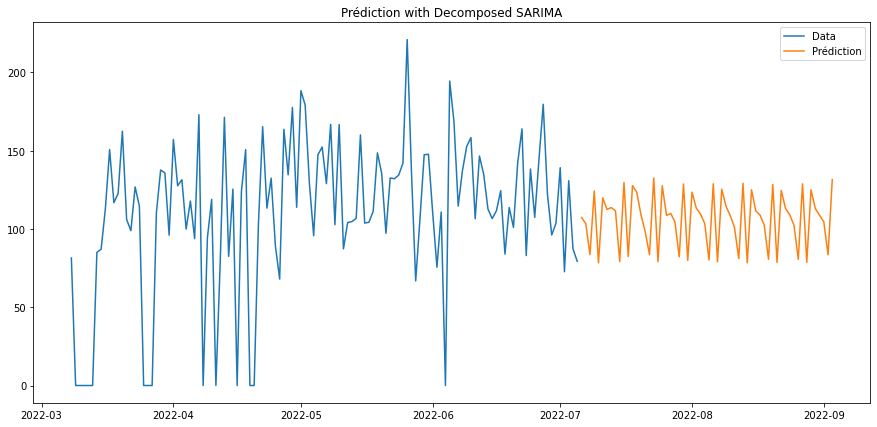

Prediction loaded loaded ... 21 s
         143
No Model loaded
         144
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 23 s


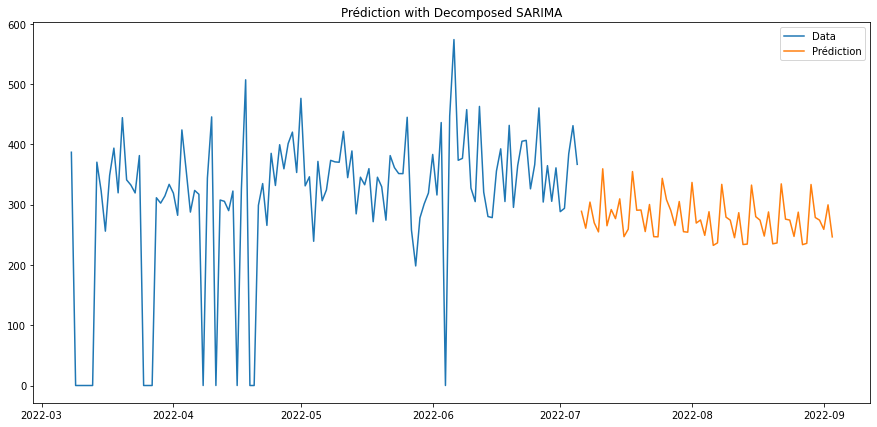

Prediction loaded loaded ... 24 s
         145
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Model loaded ... 15 s


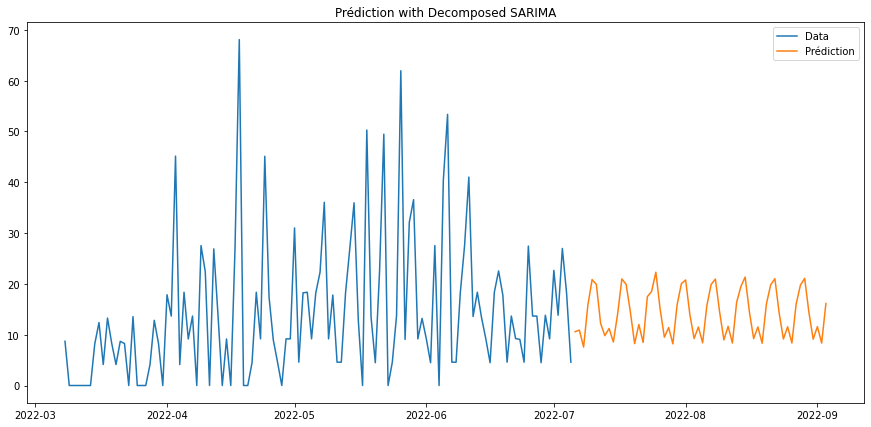

Prediction loaded loaded ... 16 s
         146
No Model loaded
         147
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 71 s


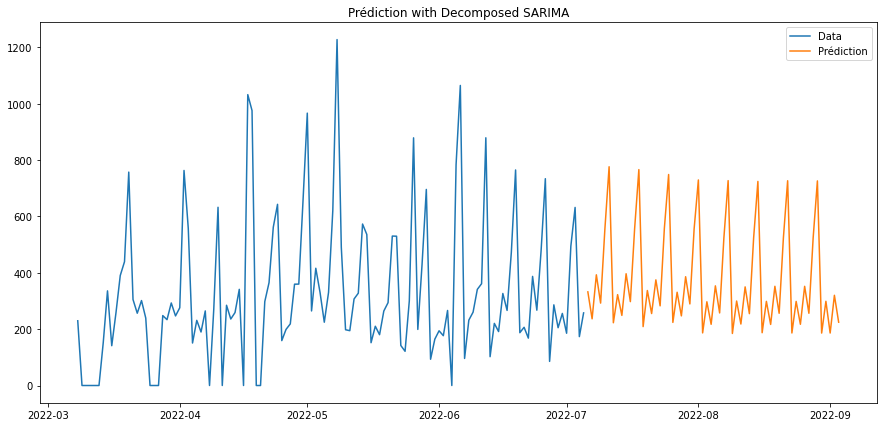

Prediction loaded loaded ... 72 s
         148
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 40 s


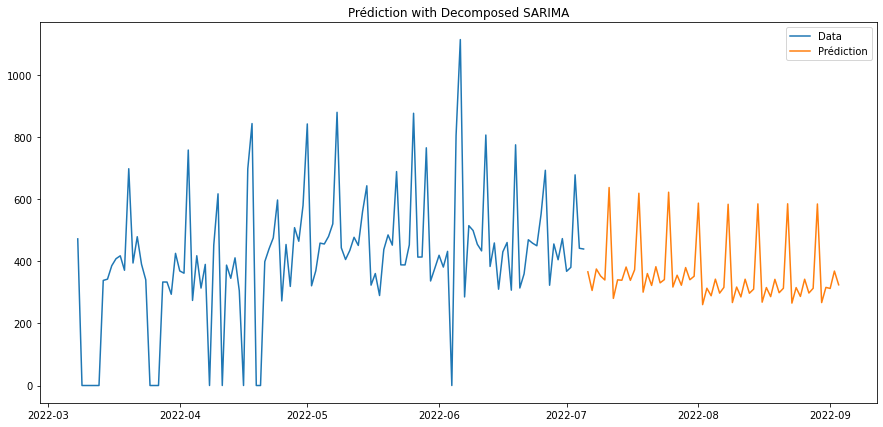

Prediction loaded loaded ... 41 s
         149
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Model loaded ... 61 s


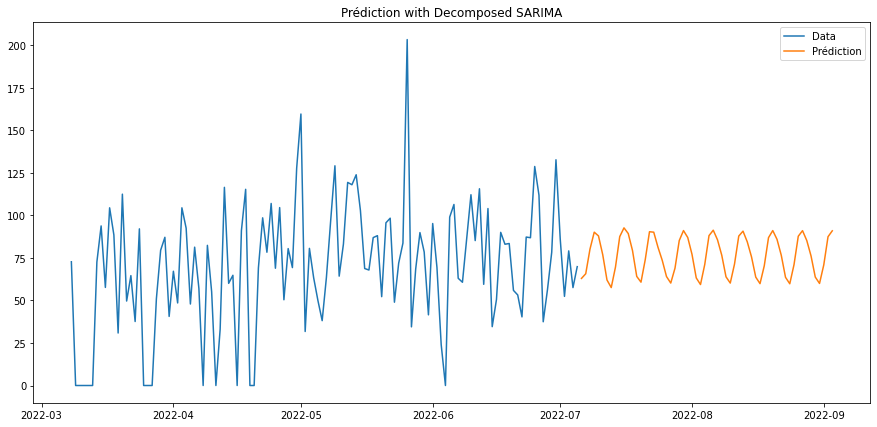

Prediction loaded loaded ... 61 s
         150
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Model loaded ... 44 s


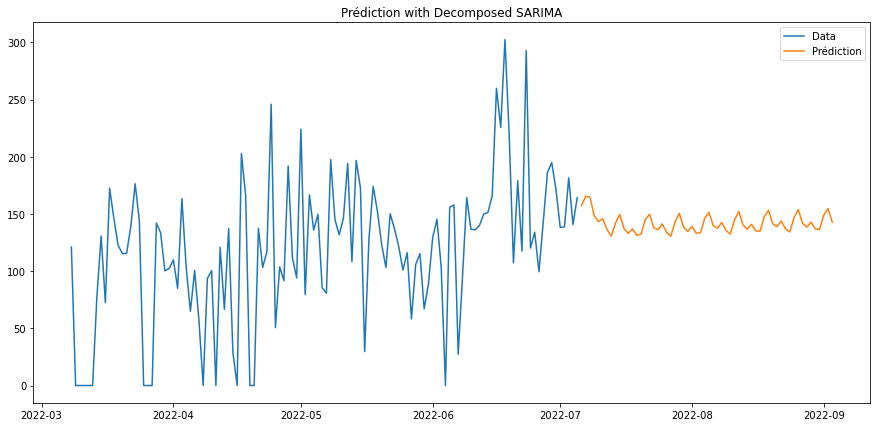

Prediction loaded loaded ... 44 s
         151
Timeseries loaded ... 0 s
Filtred Model loaded ... 30 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


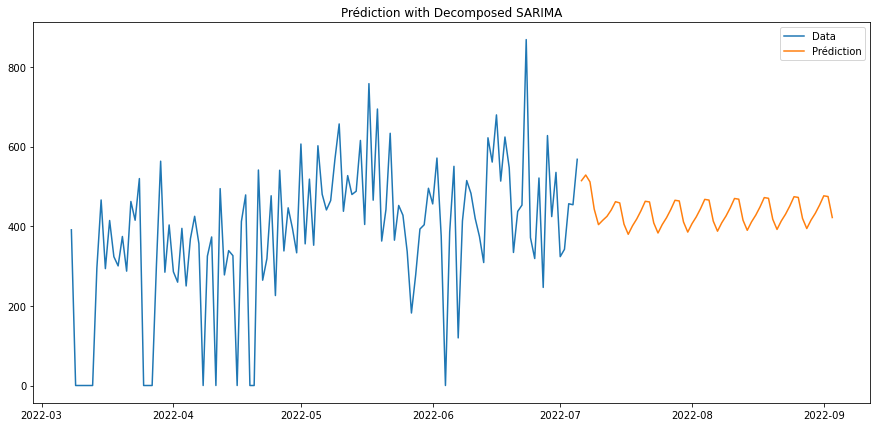

Prediction loaded loaded ... 31 s
         152
No Model loaded
         153
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 55 s


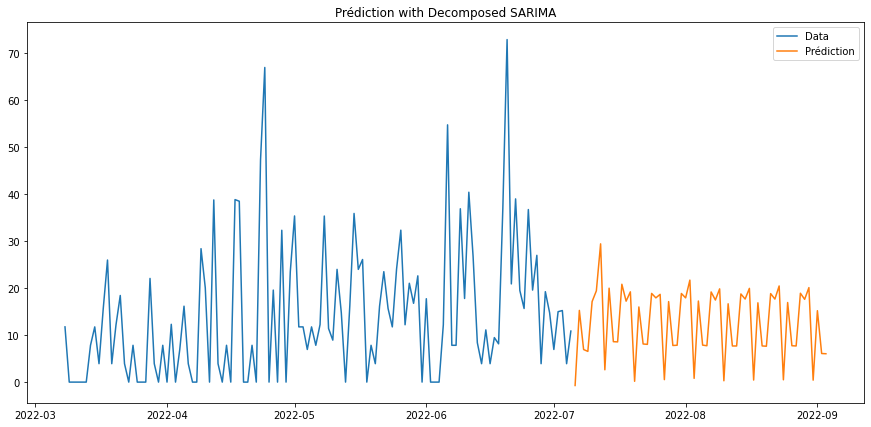

Prediction loaded loaded ... 55 s
         154
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Decomp Model loaded ... 20 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


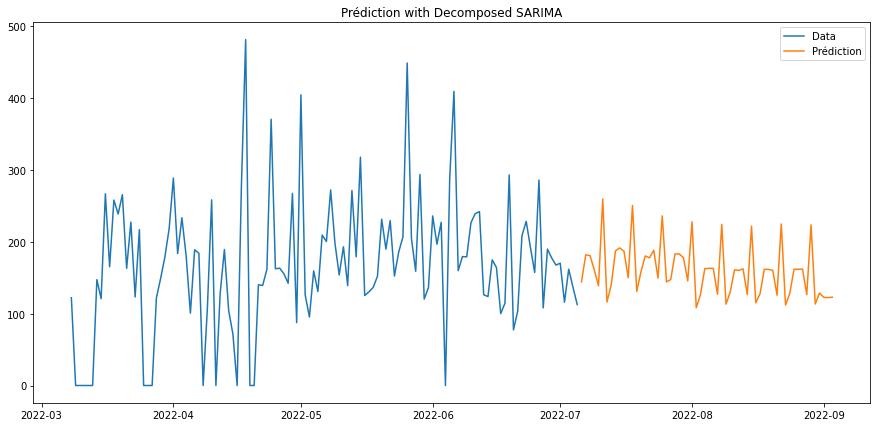

Prediction loaded loaded ... 20 s
         155
Timeseries loaded ... 0 s
Base Model loaded ... 17 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


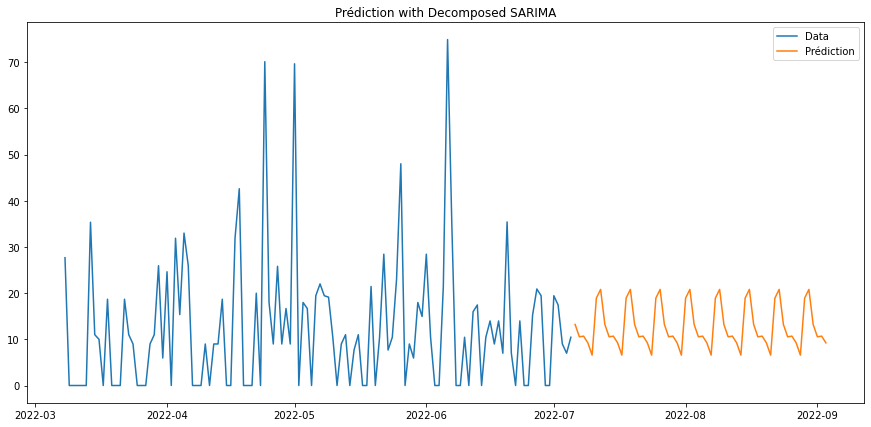

Prediction loaded loaded ... 17 s
         156
Timeseries loaded ... 0 s
Base Model loaded ... 72 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


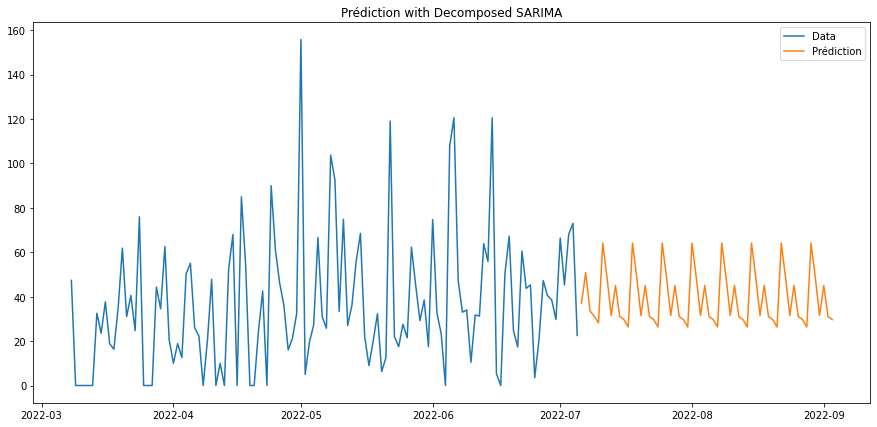

Prediction loaded loaded ... 72 s
         157
Timeseries loaded ... 0 s
Base Model loaded ... 27 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


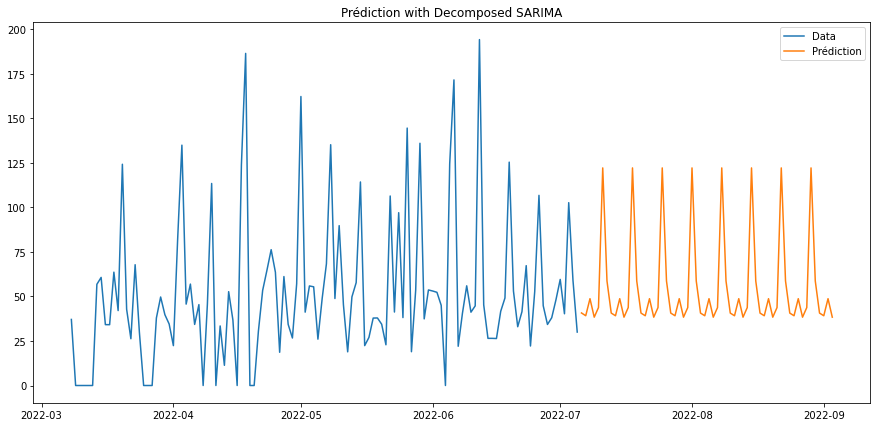

Prediction loaded loaded ... 28 s
         158
No Model loaded
         159
Timeseries loaded ... 0 s
Filtred Model loaded ... 50 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


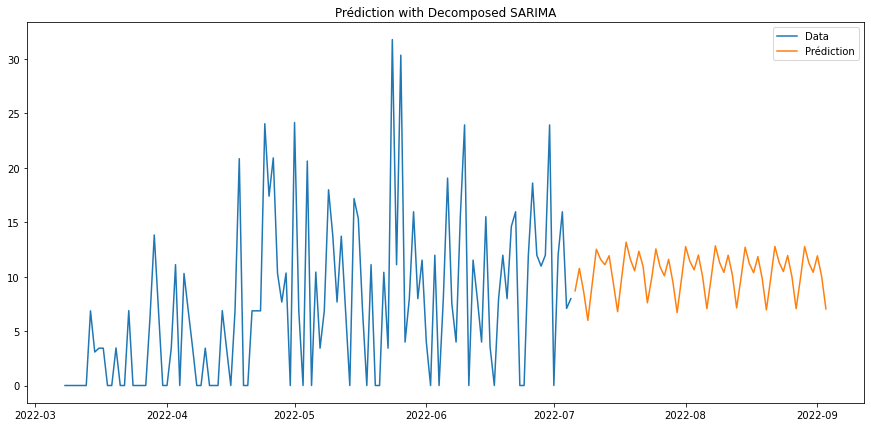

Prediction loaded loaded ... 51 s
         160
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 19 s


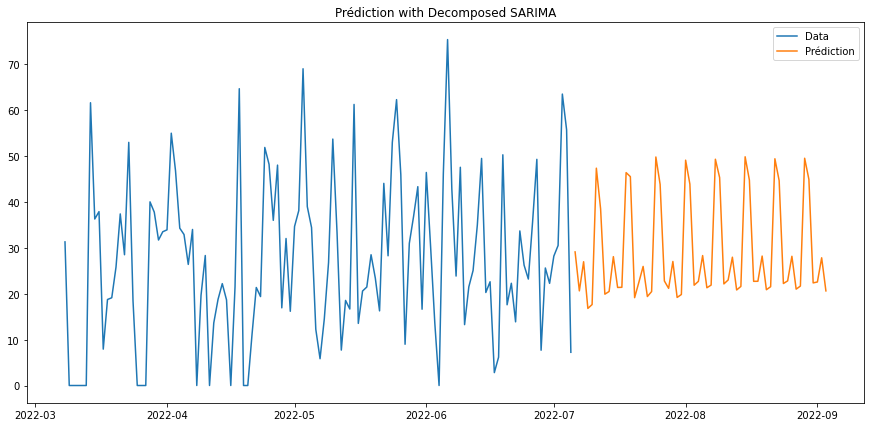

Prediction loaded loaded ... 19 s
         161
No Model loaded
         162
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Decomp Model loaded ... 26 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


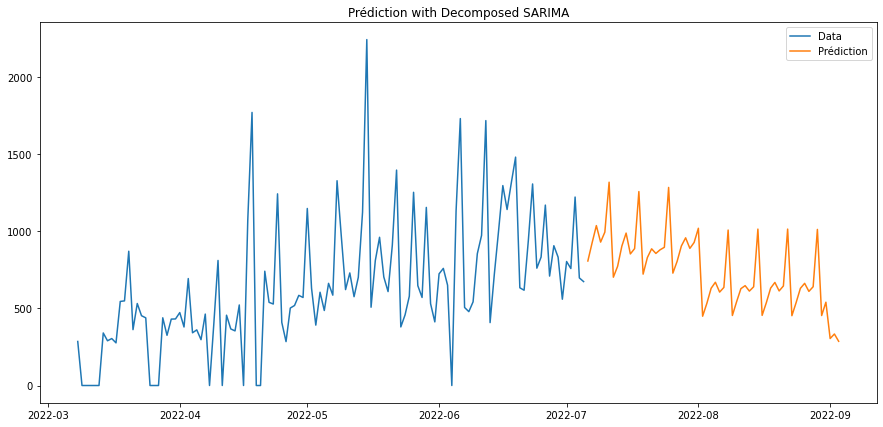

Prediction loaded loaded ... 27 s
         163
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Decomp Model loaded ... 33 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


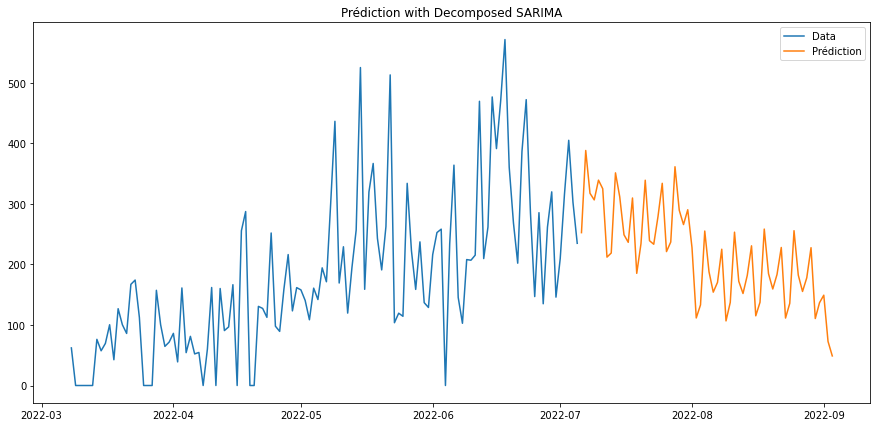

Prediction loaded loaded ... 33 s
         164
No Model loaded
         165
No Model loaded
         166
No Model loaded
         167
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Model loaded ... 48 s


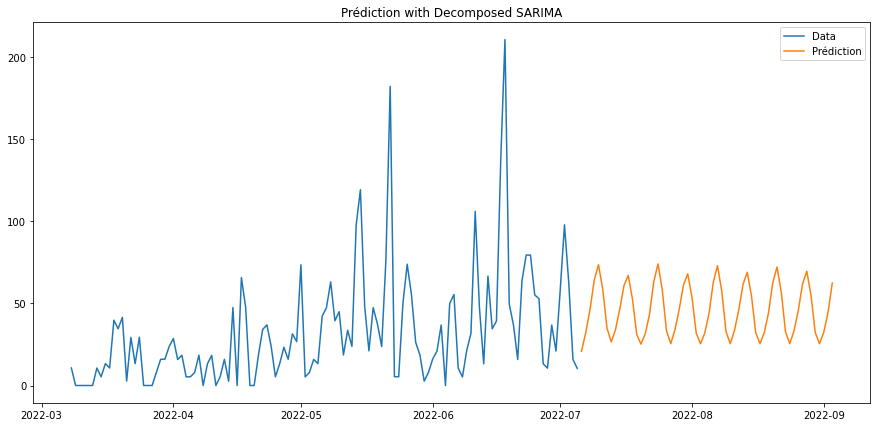

Prediction loaded loaded ... 49 s
         168
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Decomp Model loaded ... 41 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


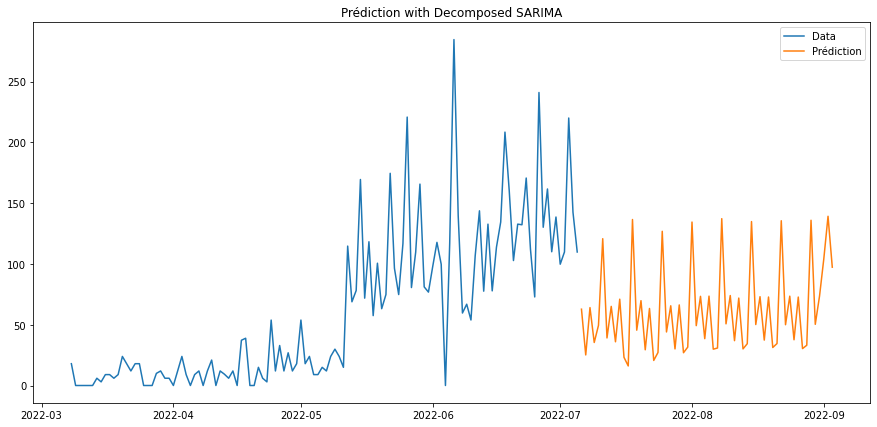

Prediction loaded loaded ... 42 s
         169


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Timeseries loaded ... 0 s
Neural Decomp Model loaded ... 25 s


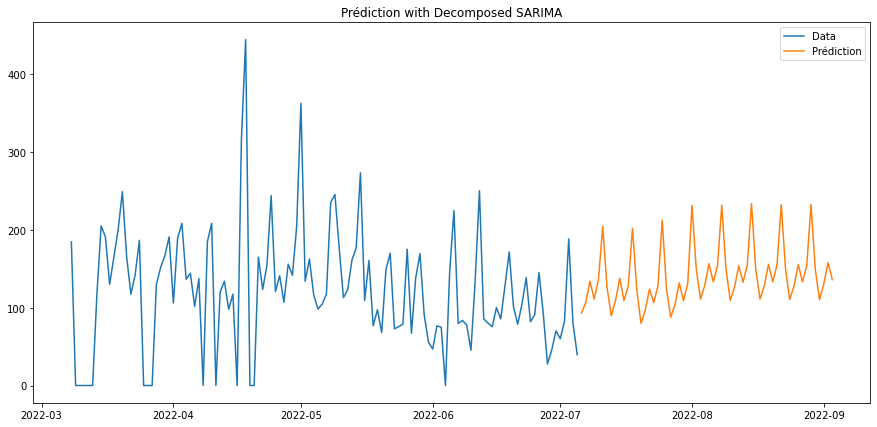

Prediction loaded loaded ... 26 s
         170
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Decomp Model loaded ... 30 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


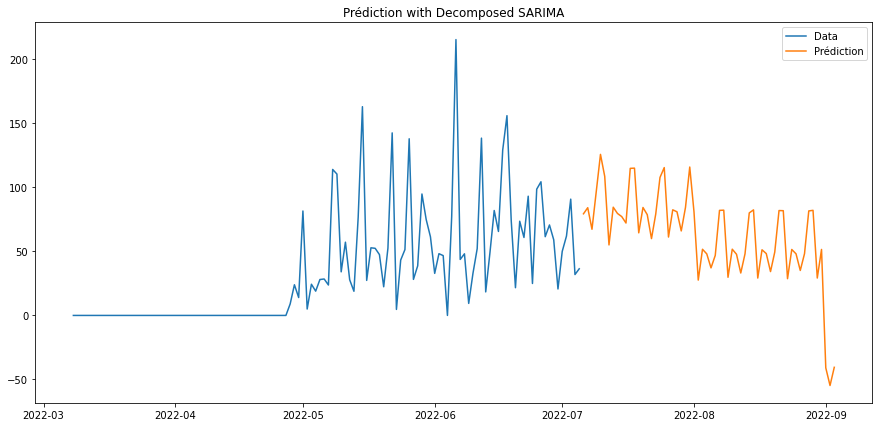

Prediction loaded loaded ... 31 s
         171
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 43 s


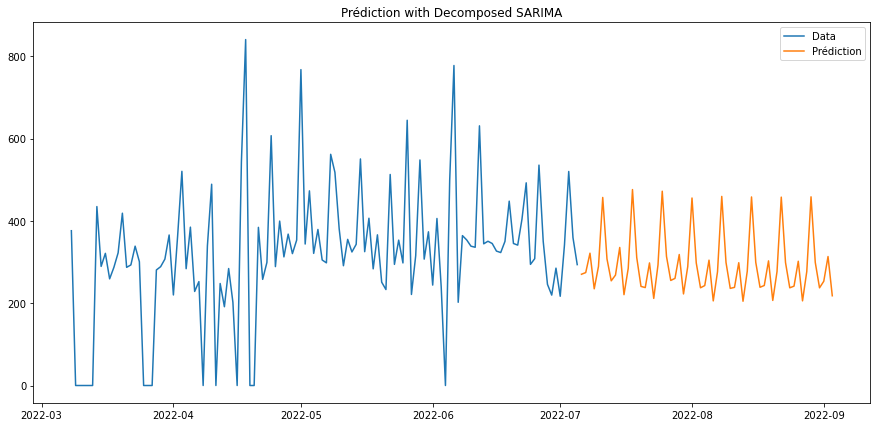

Prediction loaded loaded ... 44 s
         172
No Model loaded
         173
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Decomp Model loaded ... 23 s


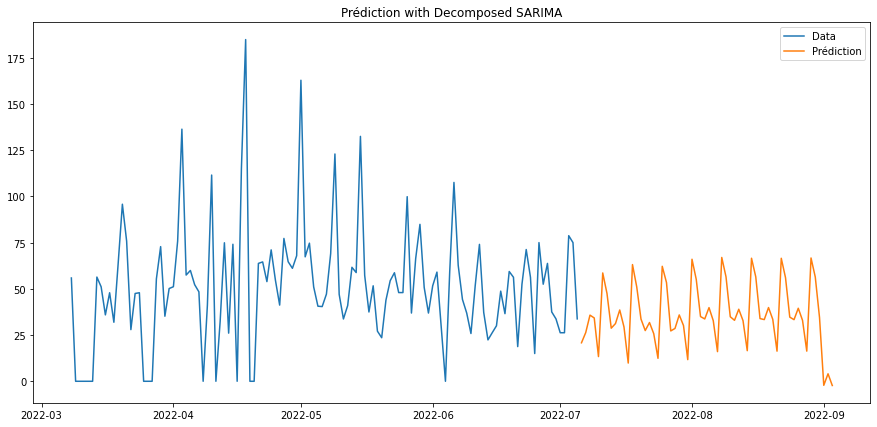

Prediction loaded loaded ... 24 s
         174
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Decomp Model loaded ... 58 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


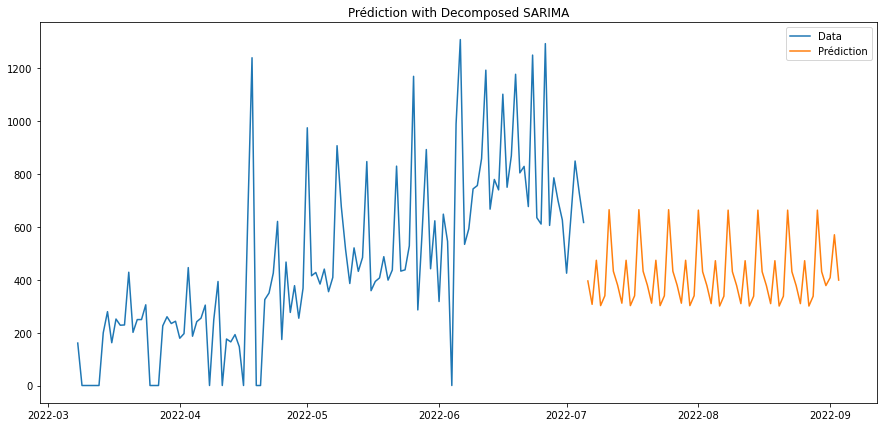

Prediction loaded loaded ... 59 s
         175
Timeseries loaded ... 0 s
Base Model loaded ... 124 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


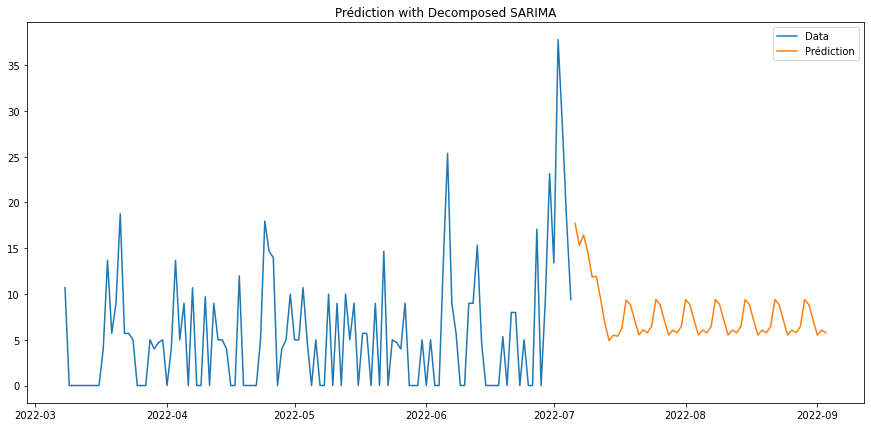

Prediction loaded loaded ... 124 s
         176
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,2)(1,1,1)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\k.dubrulle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\k.dubrulle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\k.dubrulle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\k.dubrulle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\ProgramData\Anaconda3\lib\site-pa

Neural Decomp Model loaded ... 24 s


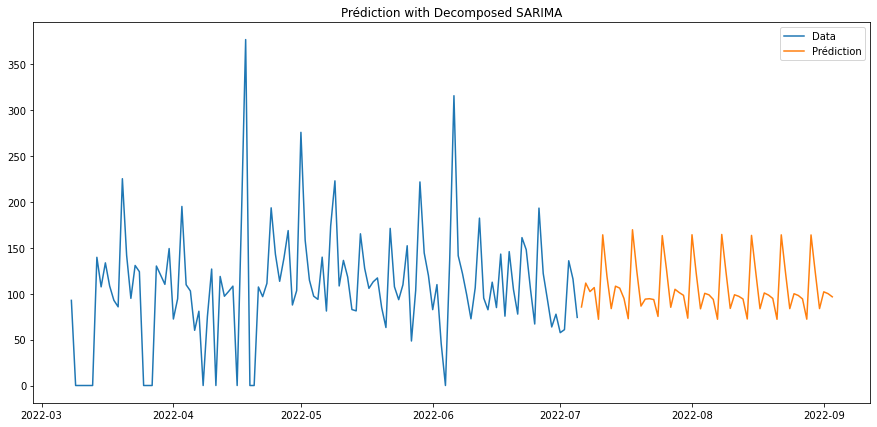

Prediction loaded loaded ... 25 s
         177
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 68 s


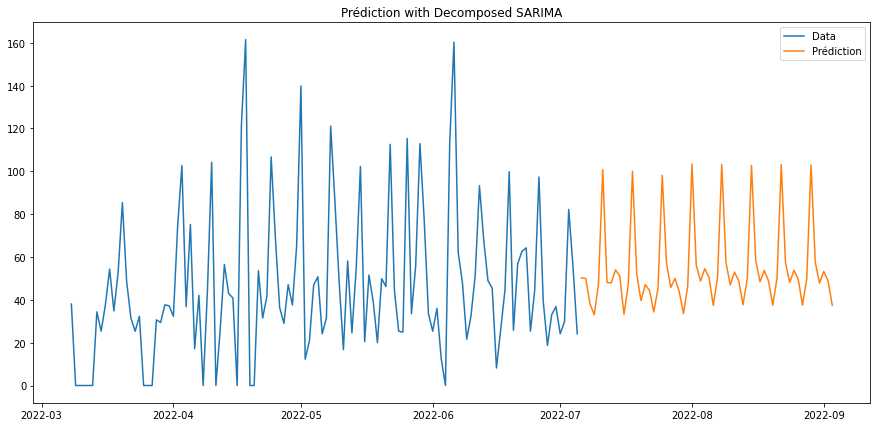

Prediction loaded loaded ... 68 s
         178
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 19 s


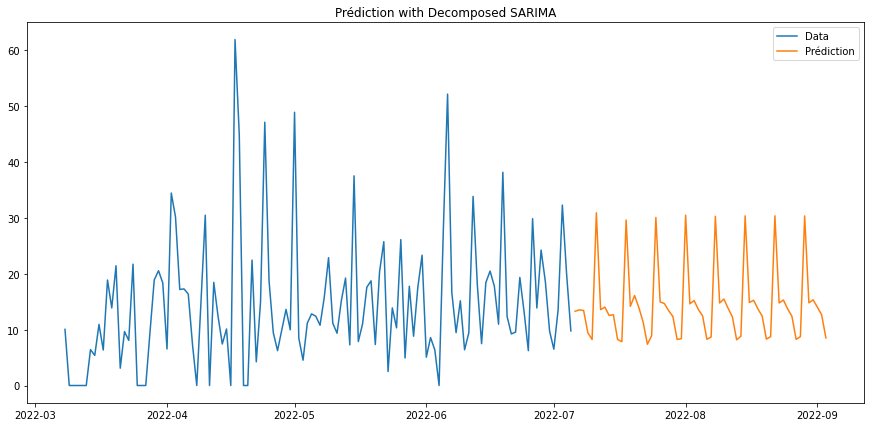

Prediction loaded loaded ... 20 s
         179
No Model loaded
         180
Timeseries loaded ... 0 s
Base Model loaded ... 32 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


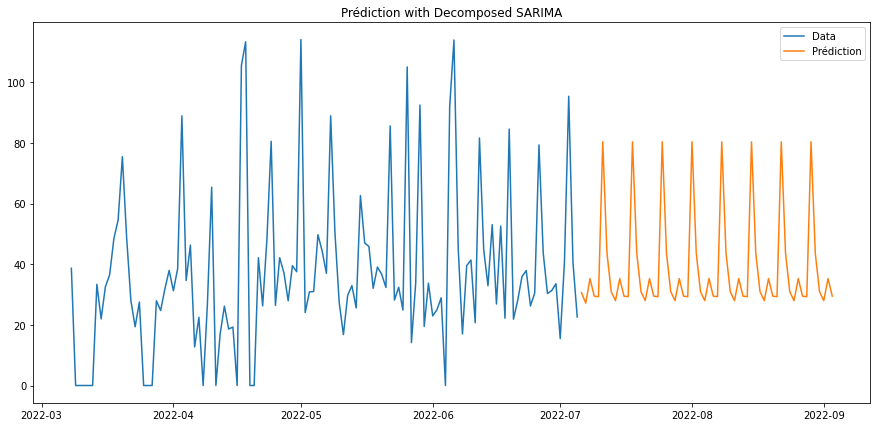

Prediction loaded loaded ... 33 s
         181
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Model loaded ... 69 s


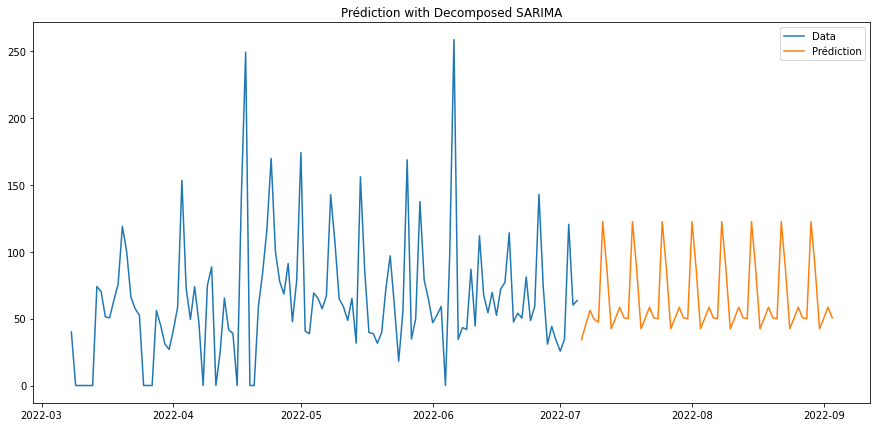

Prediction loaded loaded ... 69 s
         182
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 30 s


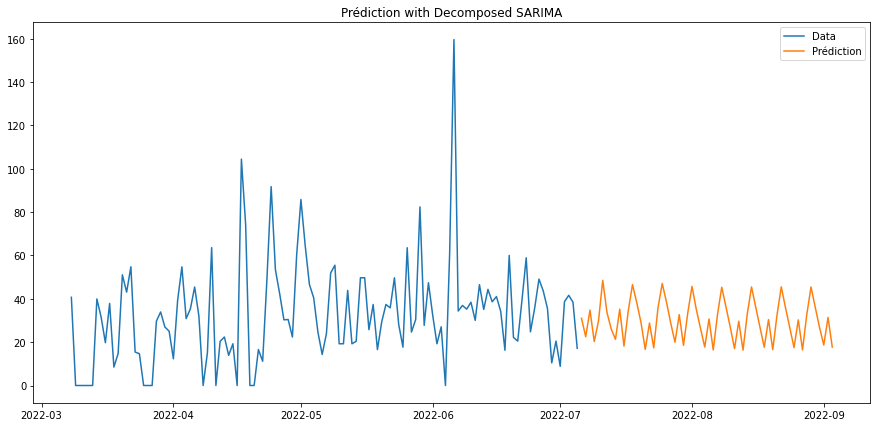

Prediction loaded loaded ... 31 s
         183
Timeseries loaded ... 0 s
Base Model loaded ... 42 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


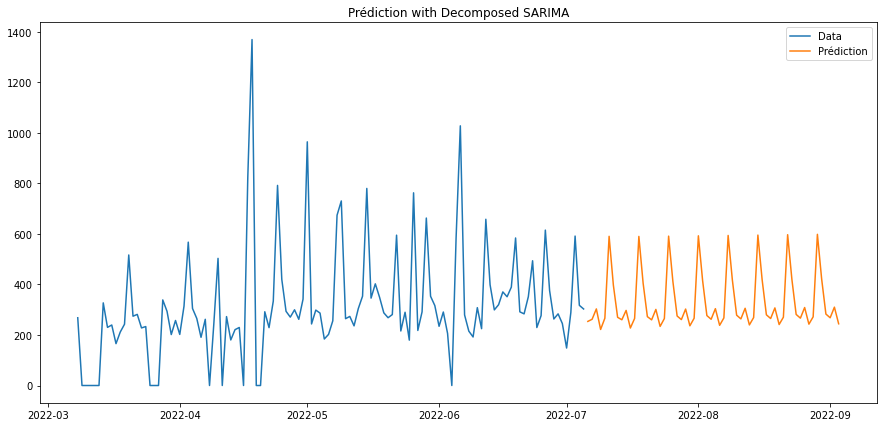

Prediction loaded loaded ... 42 s
         184
No Model loaded
         185
No Model loaded
         186
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Decomp Model loaded ... 21 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


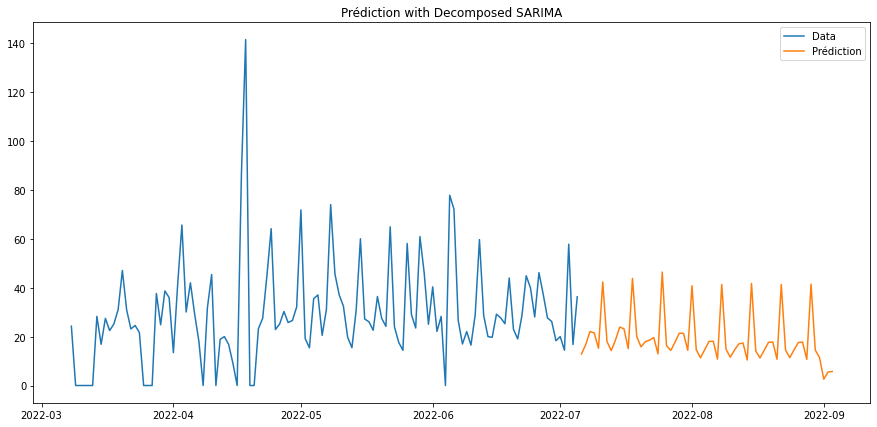

Prediction loaded loaded ... 21 s
         187
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 24 s


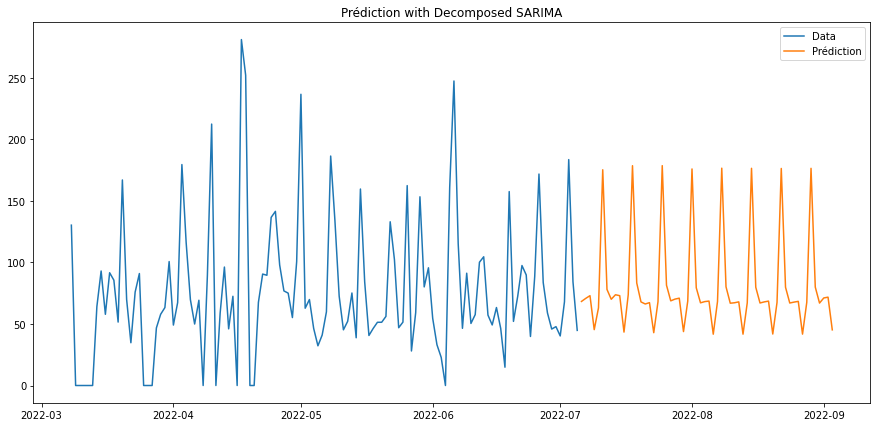

Prediction loaded loaded ... 24 s
         188
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Model loaded ... 76 s


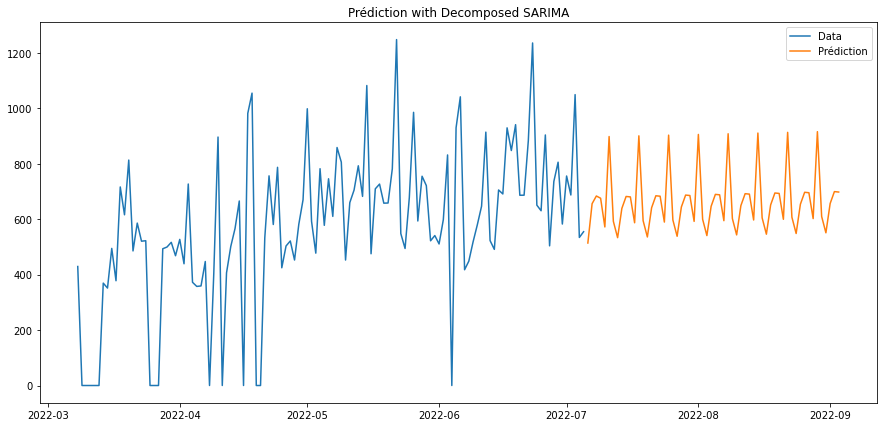

Prediction loaded loaded ... 77 s
         189
No Model loaded
         190
Timeseries loaded ... 0 s
Filtred Model loaded ... 33 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


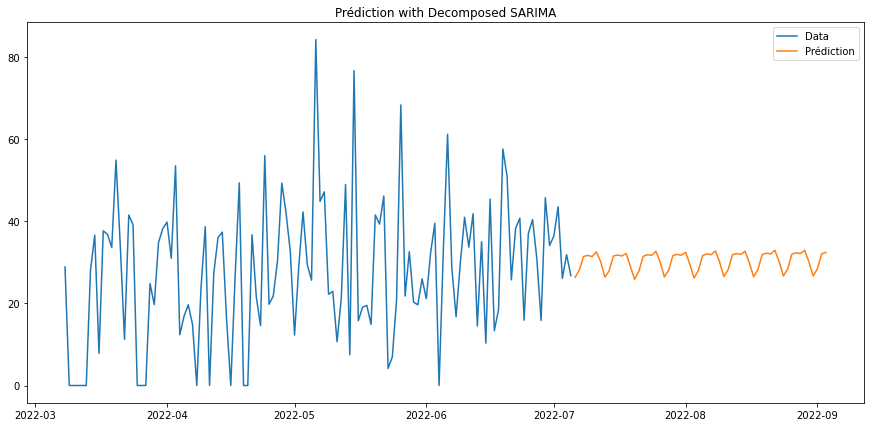

Prediction loaded loaded ... 34 s
         191
No Model loaded
         192
Timeseries loaded ... 0 s
Base Model loaded ... 36 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


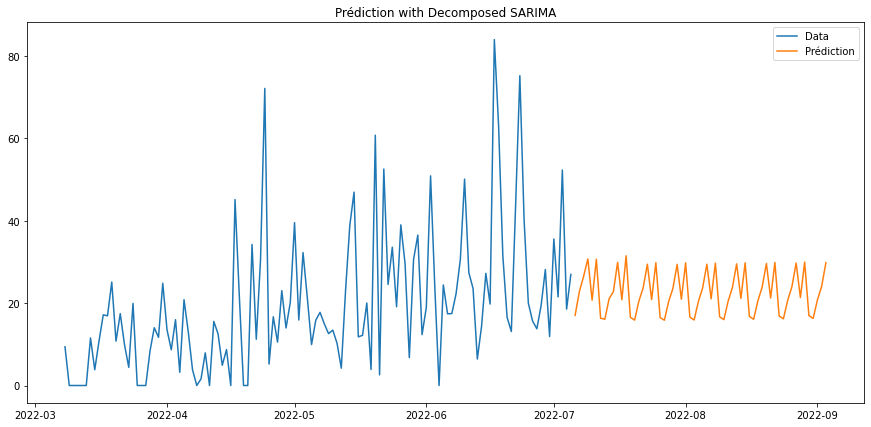

Prediction loaded loaded ... 36 s
         193
No Model loaded
         194
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Filtred Decomp Model loaded ... 45 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


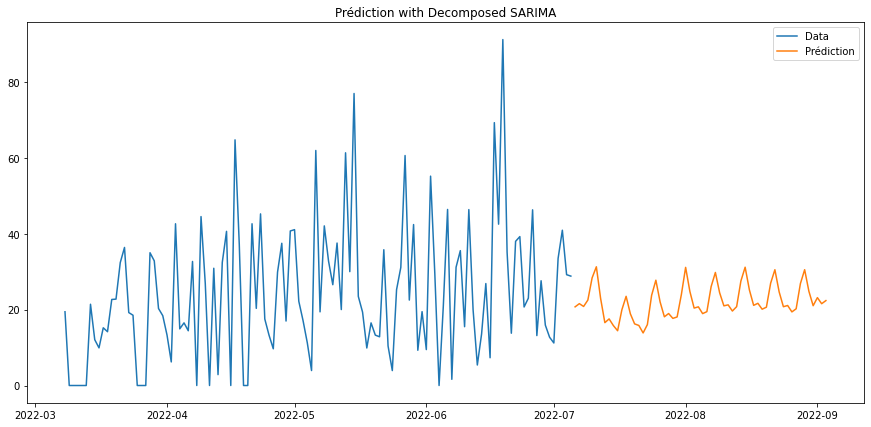

Prediction loaded loaded ... 45 s
         195
No Model loaded
         196
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Model loaded ... 12 s


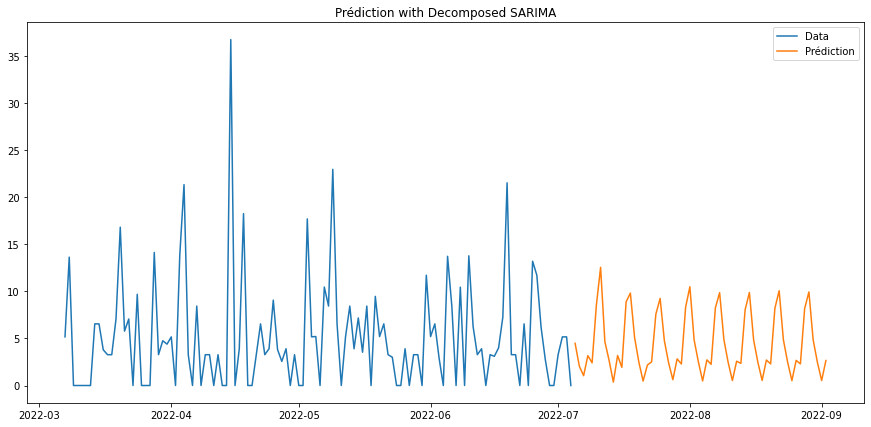

Prediction loaded loaded ... 13 s
         197
No Model loaded
         198
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Base Decomp Model loaded ... 31 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


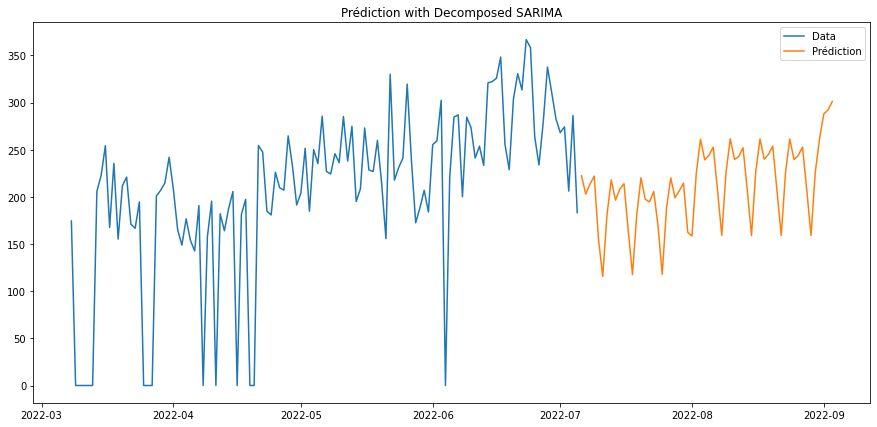

Prediction loaded loaded ... 32 s
         199
Timeseries loaded ... 0 s


C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))
C:\Users\k.dubrulle\AppData\Local\Temp\ipykernel_9164\4240307155.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  NRMSD = RMSE/(max(validation)-min(validation))


Neural Decomp Model loaded ... 18 s


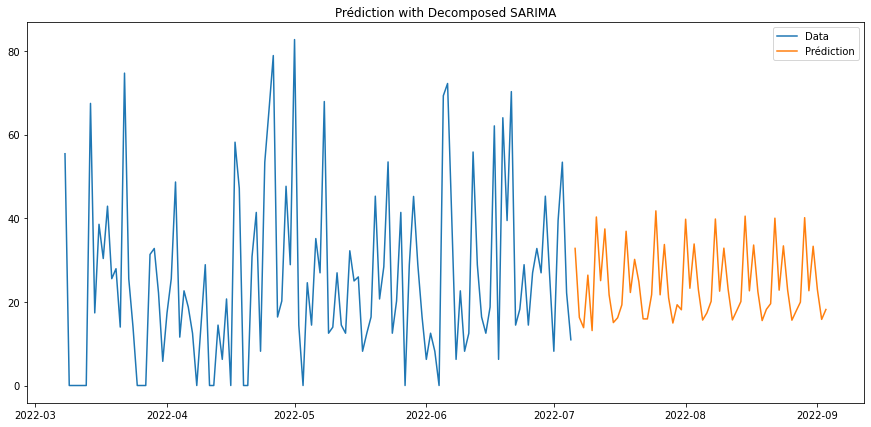

Prediction loaded loaded ... 18 s


In [56]:
day_predicted = 60
conn = engine.connect()

for key in R:
    start_pred=  time()
    print("=====================\n         " + str(key) + "\n=====================")
    
#     if len(all_df[key].values) < 1000:
#         print("Almost Empty")
#         continue
        
    
    
    sql_cmd = '''SELECT [Model.Libelle], [Model.KEY]
    FROM ['''+DB+'''].[PML].[Best_Model] 
    INNER JOIN ['''+DB+'''].[PML].[Model] 
    ON [MODEL.KEY] = [Best_Model.MODEL.KEY]
    WHERE [Best_Model.'''+TABLE_UNIVERS+'''.KEY] = ''' + str(key)

    model_df = pd.read_sql(sql_cmd, conn)
    if len(model_df.values) == 0:
        print("No Model loaded")
        continue
    model_lib = model_df.values[0][0]
    model_key = model_df.values[0][1]
    
    
    model_lib = model_lib.replace(" ", "")
    
    
    start = time()
    ts_univers = get_timeseries(all_df[key], TEMPS_DETAIL, RECETTE_DETAIL, show_plot=False)
    print("Timeseries loaded ...", int(time()-start), "s")
    
    pred = get_prediction(ts_univers, model_lib, day_predicted, TEMPS_DETAIL, RECETTE_DETAIL,
                              season = 7, method = METHOD, show_plot=True)
    
    for d in pred.index:
        sql_cmd = '''INSERT INTO ['''+DB+'''].[PML].[Recette_Prediction]
        ([Recette_Prediction.MODEL.KEY],
        [Recette_Prediction.UNIVERS.KEY],
        [Recette_Prediction.TEMPS.KEY],
        [Recette_Prediction.recette_total_ttc])
        VALUES ('''+str(model_key)+''', '''+str(key)+''', '''+str(date_to_key(d))+''','''+str(round(pred[d],2))+''')'''
                                                                                             
#         print(sql_cmd)
        conn.execute(sql_cmd)
    
    
    print("Prediction loaded loaded ...", int(time()-start_pred), "s")

conn.close()

In [ ]:
# day_predicted = 60
# models = ["base","baseD","filtredD","filtred", "neural"]
# for key in range(219,220):
#     print("=====================\n         " + str(key) + "\n=====================")
    
#     if len(all_df[key].values) < 1000:
#         print("Almost Empty")
#         continue
        
#     start = time()
#     ts_univers = get_timeseries(all_df[key], TEMPS_DETAIL, RECETTE_DETAIL, show_plot=False)
#     print("Timeseries loaded ...", int(time()-start), "s")
    
#     model = models[key%5]
    
#     pred = get_prediction(ts_univers, model, day_predicted, TEMPS_DETAIL, RECETTE_DETAIL,
#                               season = 7, method = METHOD, show_plot=True)
    
#     print(pred)